# Saliency map evaluation

In [5]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import math

from scipy.ndimage import gaussian_filter, zoom
from IPython.display import Video

from functools import partial
import numpy as np
from numpy import random
from skimage import exposure
from skimage.transform import resize

import os


import openpyxl

import cv2

## Preprocessing


In [14]:
def preprocessing_tsv(path):
    data = pd.read_csv(path, sep='\t')

    data = data[['Recording timestamp', 'Presented Stimulus name', 'Fixation point X (MCSnorm)', 'Fixation point Y (MCSnorm)', 'Validity left', 'Validity right']]
    data['Presented Stimulus name'] = data['Presented Stimulus name'].str[7:]
    data = data.rename(columns={'Presented Stimulus name': 'Video'})

    data['Fixation point X'] = data['Fixation point X (MCSnorm)']
    data['Fixation point Y'] = data['Fixation point Y (MCSnorm)']
    data['Fixation point X'] = data['Fixation point X'].str.replace(',', '.').astype(float)
    data['Fixation point Y'] = data['Fixation point Y'].str.replace(',', '.').astype(float)
    data['Fixation point X'] = data['Fixation point X'] * 224
    data['Fixation point Y'] = data['Fixation point Y'] * 224
    data['Fixation point X'] = data['Fixation point X'].round(0)
    data['Fixation point Y'] = data['Fixation point Y'].round(0)
    
    data = data.dropna()

    return data



def fixations_of_a_video(video, data):
    data = data[data['Video'].str.contains(video)]

    heatmaps = np.zeros((224, 224, 16))

    for index, row in data.iterrows():
        x = int(row['Fixation point X'])
        y = int(row['Fixation point Y'])
        time = int(row['Recording timestamp']) // 1000
        time = time % 16

        if x >= 0 and x < 224 and y >= 0 and y < 224:
            heatmaps[y, x, time] += 1

    return heatmaps


def saliency_16th(video, all_data):
    #create an array of maps 224X224x16 for each of the participants, one entry in the all_data list
    all_maps = []
    for data in all_data:
        all_maps.append(fixations_of_a_video(video, data))


    #distribution_map is the sum of the entries of the map for all the participants
    distribution_map = np.zeros((224, 224, 16))

    for i in range(16):
        for j in range(len(all_maps)):
            distribution_map[:, :, i] += all_maps[j][:, :, i]
            
            
    return distribution_map

In [15]:
data1= preprocessing_tsv('gaze_raw_data/S001gaze2D_allTrials.tsv')
data2= preprocessing_tsv('gaze_raw_data/S002gaze2D_allTrials.tsv')
data3= preprocessing_tsv('gaze_raw_data/S003gaze2D_allTrials.tsv')
data5= preprocessing_tsv('gaze_raw_data/S005gaze2D_allTrials.tsv')
data7= preprocessing_tsv('gaze_raw_data/S007gaze2D_allTrials.tsv')
data8= preprocessing_tsv('gaze_raw_data/S008gaze2D_allTrials.tsv')
data4= preprocessing_tsv('gaze_raw_data/S004gaze2D_allTrials.tsv')
data6= preprocessing_tsv('gaze_raw_data/S006gaze2D_allTrials.tsv')
data9= preprocessing_tsv('gaze_raw_data/S009gaze2D_allTrials.tsv')

adults = [data1, data2, data3, data4, data5, data6, data7, data8, data9]

In [40]:
gaze_videos=[ '1_ab_WS_Physical__r1__100', '1_bc_SW_Help__r3__100','1_bc_SW_Physical__r3__100','1_bc_WS_Hinder__r3__100','1_ca_SW_Help__r2__100','1_ca_SW_Hinder__r2__100','1_ca_WS_Physical__r2__100', '3_ab_SW_Hinder__r5__100','3_ab_WS_Help__r5__100', '3_bc_WS_Help__r4__100']

#gaze_videos_2=['3_ca_WS_Hinder__r6__100', '1_ab_WS_Help__r1__100', '1_ab_WS_Physical__r1__100', '3_bc_WS_Help__r4__100', '1_ab_WS_Hinder__r1__100', '3_bc_WS_Hinder__r4__100', '1_ca_WS_Physical__r2__100', '3_ab_WS_Physical__r5__100', '1_ca_WS_Help__r2__100', '3_ab_WS_Help__r5__100', '1_ca_WS_Hinder__r2__100', '3_ab_WS_Hinder__r5__100', '1_bc_WS_Physical__r3__100', '3_ca_WS_Physical__r6__100', '1_bc_WS_Help__r3__100', '3_ca_WS_Help__r6__100', '1_bc_WS_Hinder__r3__100', '3_bc_WS_Physical__r4__100']
# gaze_videos_3 = ['3_ca_SW_Hinder__r6__100','1_ab_SW_Help__r1__100','1_ab_SW_Physical__r1__100','3_bc_SW_Help__r4__100','1_ab_SW_Hinder__r1__100','3_bc_SW_Hinder__r4__100','1_ca_SW_Physical__r2__100','3_ab_SW_Physical__r5__100','1_ca_SW_Help__r2__100','3_ab_SW_Help__r5__100','1_ca_SW_Hinder__r2__100','3_ab_SW_Hinder__r5__100','1_bc_SW_Physical__r3__100','3_ca_SW_Physical__r6__100','1_bc_SW_Help__r3__100','3_ca_SW_Help__r6__100','1_bc_SW_Hinder__r3__100','3_bc_SW_Physical__r4__100']

#creare a folder in /temporal_comparison/fixations for each of the name in gaze videos
for name in gaze_videos:
    path = f'/temporal_comparison/fixations/{name}'
    try:
        os.makedirs(path)
    except FileExistsError:
        pass

 # for video in gaze_videos: create a new tsv in fixation folder
for video in gaze_videos:
    subject_n = 1
    for data in adults:
        data = data[data['Video'].str.contains(video)]
        #drop column of viddoe
        data = data.drop(columns=['Video'])
        #drop column validity left and right
        data = data.drop(columns=['Validity left', 'Validity right'])
        #drop Fixation point X (MCSnorm)	Fixation point Y (MCSnorm)
        data = data.drop(columns=['Fixation point X (MCSnorm)', 'Fixation point Y (MCSnorm)'])

        #round the values to integer
        data['Fixation point X'] = data['Fixation point X'].astype(int)
        data['Fixation point Y'] = data['Fixation point Y'].astype(int)


        number_subj = str(subject_n)

        data.to_csv('fixations/'+ str(video) + '/subject_'+ number_subj + '.tsv', sep='\t', index=False)
        subject_n += 1

        #per fermarsi a nove
        if subject_n > 9:
            break

## Comparison

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import math

from scipy.ndimage import gaussian_filter
from IPython.display import Video

## GradCAM

In [184]:
#PREPROCESSING THE HEATMAPS GIVEN FROM THE GRADCAM SCRIPT

gaze_videos=[ '1_ab_WS_Physical__r1__100', '1_bc_SW_Help__r3__100','1_bc_SW_Physical__r3__100','1_bc_WS_Hinder__r3__100','1_ca_SW_Help__r2__100','1_ca_SW_Hinder__r2__100','1_ca_WS_Physical__r2__100', '3_ab_SW_Hinder__r5__100','3_ab_WS_Help__r5__100', '3_bc_WS_Help__r4__100']
#gaze_videos_2=['3_ca_WS_Hinder__r6__100', '1_ab_WS_Help__r1__100', '1_ab_WS_Physical__r1__100', '3_bc_WS_Help__r4__100', '1_ab_WS_Hinder__r1__100', '3_bc_WS_Hinder__r4__100', '1_ca_WS_Physical__r2__100', '3_ab_WS_Physical__r5__100', '1_ca_WS_Help__r2__100', '3_ab_WS_Help__r5__100', '1_ca_WS_Hinder__r2__100', '3_ab_WS_Hinder__r5__100', '1_bc_WS_Physical__r3__100', '3_ca_WS_Physical__r6__100', '1_bc_WS_Help__r3__100', '3_ca_WS_Help__r6__100', '1_bc_WS_Hinder__r3__100', '3_bc_WS_Physical__r4__100']
# gaze_videos_3 = ['3_ca_SW_Hinder__r6__100','1_ab_SW_Help__r1__100','1_ab_SW_Physical__r1__100','3_bc_SW_Help__r4__100','1_ab_SW_Hinder__r1__100','3_bc_SW_Hinder__r4__100','1_ca_SW_Physical__r2__100','3_ab_SW_Physical__r5__100','1_ca_SW_Help__r2__100','3_ab_SW_Help__r5__100','1_ca_SW_Hinder__r2__100','3_ab_SW_Hinder__r5__100','1_bc_SW_Physical__r3__100','3_ca_SW_Physical__r6__100','1_bc_SW_Help__r3__100','3_ca_SW_Help__r6__100','1_bc_SW_Hinder__r3__100','3_bc_SW_Physical__r4__100']

def parse_heatmap_file(file_name):
    #open the file
    with open(file_name, 'r') as file:
        lines = file.readlines()

    #a dictionary for the date is initialised
    frame_data = {}
    current_frame = None

    #analyze the row of the file
    for line in lines:
        if line.startswith("Frame"):  # find the beginning of the values of one frame
            current_frame = int(line.split()[1]) - 1
            frame_data[current_frame] = []  # a list for the file of this frame
        elif "Heatmap values:" in line:
            continue  # Skip the line that contains "Heatmap values:"
        else:  # line with values
            values = list(map(float, line.split()))
            frame_data[current_frame].extend(values)

    # create a dataframe with collected data
    df = pd.DataFrame.from_dict(frame_data, orient='index')

    # rename the row of the DataFrame with "Frame {n}"
    df.index = [f"Frame {i}" for i in range(len(frame_data))]

    return df

# function that sum and normalize data
def process_heatmap_data(df):
    #for each of the 16 frame, normalize the heatmap
    df = df.div(df.max(axis=1), axis=0)

    #return a 16 x 224 x 224 matrix
    heatmap_2d = np.zeros((224, 224, 16))
    for i in range(16):
        heatmap_2d[:, :, i] = df.iloc[i].values.reshape(224, 224)

    return heatmap_2d

#let's have a look to all the heatmaps
for video in gaze_videos_complete:
    file_name = f'gradcams/{video}_grad.txt'
    df = parse_heatmap_file(file_name)

    # Somma e normalizzazione
    normalized_heatmap = process_heatmap_data(df)

    #save the heatmap in a folder
    np.save(f'gradcams/{video}_gradCAMs.npy', normalized_heatmap)


## Fixations

In [29]:
#now let's create an overall heatmap for all subjects that approximate the human visual attention distribution
#for all tsv in notebook_data folder create an heatmap and sum them all
for video in gaze_videos:
    temporal_Fixation_map = np.zeros((224, 224,16))
    for i in range(1, 10):
        df_humans = pd.read_csv(f'fixations/{video}/subject_{i}.tsv', sep='\t')
        time_0= df_humans['Recording timestamp'].iloc[0]
        time_final=df_humans['Recording timestamp'].iloc[-1]
        for index, row in df_humans.iterrows():
            x = int(row['Fixation point X'])
            y = int(row['Fixation point Y'])
            timestamp=int(row['Recording timestamp'])

            window=int((timestamp-time_0)/((time_final-time_0)/16))

            if x >= 0 and x < 224 and y >= 0 and y < 224 and window<16:
                temporal_Fixation_map[y, x, window] += 1


    #save temporal_Fixation_map as npy file
    np.save(f'fixations/{video}/temporal_Fixation_map.npy', temporal_Fixation_map)

## Saliency metrics for evaluation

This implementations of the metrics follows those found in [this ](https://github.com/herrlich10/saliency) and [this](https://github.com/tarunsharma1/saliency_metrics/tree/master) repositories.


This implementations of the metrics follows those found in [this ](https://github.com/herrlich10/saliency) and [this](https://github.com/tarunsharma1/saliency_metrics/tree/master) repositories.


In [30]:
def normalize(x, method='standard', axis=None):
    '''Normalizes the input with specified method.

    Parameters
    ----------
    x : array-like
    method : string, optional
        Valid values for method are:
        - 'standard': mean=0, std=1
        - 'range': min=0, max=1
        - 'sum': sum=1
    axis : int, optional
        Axis perpendicular to which array is sliced and normalized.
        If None, array is flattened and normalized.

    Returns
    -------
    res : numpy.ndarray
        Normalized array.
    '''
    x = np.array(x, copy=False)
    if axis is not None:
        y = np.rollaxis(x, axis).reshape([x.shape[axis], -1])
        shape = np.ones(len(x.shape))
        shape[axis] = x.shape[axis]
        if method == 'standard':
            res = (x - np.mean(y, axis=1).reshape(shape)) / np.std(y, axis=1).reshape(shape)
        elif method == 'range':
            res = (x - np.min(y, axis=1).reshape(shape)) / (np.max(y, axis=1) - np.min(y, axis=1)).reshape(shape)
        elif method == 'sum':
            res = x / np.float_(np.sum(y, axis=1).reshape(shape))
        else:
            raise ValueError('method not in {"standard", "range", "sum"}')
    else:
        if method == 'standard':
            res = (x - np.mean(x)) / np.std(x)
        elif method == 'range':
            res = (x - np.min(x)) / (np.max(x) - np.min(x))
        elif method == 'sum':
            res = x / float(np.sum(x))
        else:
            raise ValueError('method not in {"standard", "range", "sum"}')
    return res


'''
Commonly used metrics for evaluating saliency map performance.

Most metrics are ported from Matlab implementation provided by http://saliency.mit.edu/
Bylinskii, Z., Judd, T., Durand, F., Oliva, A., & Torralba, A. (n.d.). MIT Saliency Benchmark.

Python implementation: Chencan Qian, Sep 2014
'''

from functools import partial
import numpy as np
from numpy import random
from skimage import exposure
from skimage.transform import resize


def AUC_Judd(saliency_map, fixation_map, jitter=True):
    '''
    AUC stands for Area Under ROC Curve.
    This measures how well the saliency map of an image predicts the ground truth human fixations on the image.

    ROC curve is created by sweeping through threshold values
    determined by range of saliency map values at fixation locations.
    True positive (tp) rate correspond to the ratio of saliency map values above threshold
    at fixation locations to the total number of fixation locations.
    False positive (fp) rate correspond to the ratio of saliency map values above threshold
    at all other locations to the total number of possible other locations (non-fixated image pixels).

    AUC=0.5 is chance level.

    Parameters
    ----------
    saliency_map : real-valued matrix
    fixation_map : binary matrix
        Human fixation map.
    jitter : boolean, optional
        If True (default), a small random number would be added to each pixel of the saliency map.
        Jitter saliency maps that come from saliency models that have a lot of zero values.
        If the saliency map is made with a Gaussian then it does not need to be jittered
        as the values vary and there is not a large patch of the same value.
        In fact, jittering breaks the ordering in the small values!

    Returns
    -------
    AUC : float, between [0,1]
    '''
    saliency_map = np.array(saliency_map, copy=False)
    fixation_map = np.array(fixation_map, copy=False) > 0.5
    # If there are no fixation to predict, return NaN
    if not np.any(fixation_map):
        print('no fixation to predict')
        return np.nan
    # Make the saliency_map the size of the fixation_map
    if saliency_map.shape != fixation_map.shape:
        saliency_map = resize(saliency_map, fixation_map.shape, order=3, mode='nearest')
    # Jitter the saliency map slightly to disrupt ties of the same saliency value
    if jitter:
        saliency_map += random.rand(*saliency_map.shape) * 1e-7
    # Normalize saliency map to have values between [0,1]
    saliency_map = normalize(saliency_map, method='range')

    S = saliency_map.ravel()
    F = fixation_map.ravel()
    S_fix = S[F] # Saliency map values at fixation locations
    n_fix = len(S_fix)
    n_pixels = len(S)
    # Calculate AUC
    thresholds = sorted(S_fix, reverse=True)
    tp = np.zeros(len(thresholds)+2)
    fp = np.zeros(len(thresholds)+2)
    tp[0] = 0; tp[-1] = 1
    fp[0] = 0; fp[-1] = 1
    for k, thresh in enumerate(thresholds):
        above_th = np.sum(S >= thresh) # Total number of saliency map values above threshold
        tp[k+1] = (k + 1) / float(n_fix) # Ratio saliency map values at fixation locations above threshold
        fp[k+1] = (above_th - k - 1) / float(n_pixels - n_fix) # Ratio other saliency map values above threshold
    return np.trapz(tp, fp) # y, x


def NSS(saliency_map, fixation_map):
    '''
    Normalized scanpath saliency of a saliency map,
    defined as the mean value of normalized (i.e., standardized) saliency map at fixation locations.
    You can think of it as a z-score. (Larger value implies better performance.)

    Parameters
    ----------
    saliency_map : real-valued matrix
        If the two maps are different in shape, saliency_map will be resized to match fixation_map..
    fixation_map : binary matrix
        Human fixation map (1 for fixated location, 0 for elsewhere).

    Returns
    -------
    NSS : float, positive
    '''
    s_map = np.array(saliency_map, copy=False)
    f_map = np.array(fixation_map, copy=False) > 0.5
    if s_map.shape != f_map.shape:
        s_map = resize(s_map, f_map.shape)
    # Normalize saliency map to have zero mean and unit std
    s_map = normalize(s_map, method='standard')
    # Mean saliency value at fixation locations
    return np.mean(s_map[f_map])


def CC(saliency_map1, saliency_map2):
    '''
    Pearson's correlation coefficient between two different saliency maps
    (CC=0 for uncorrelated maps, CC=1 for perfect linear correlation).

    Parameters
    ----------
    saliency_map1 : real-valued matrix
        If the two maps are different in shape, saliency_map1 will be resized to match saliency_map2.
    saliency_map2 : real-valued matrix

    Returns
    -------
    CC : float, between [-1,1]
    '''
    map1 = np.array(saliency_map1, copy=False)
    map2 = np.array(saliency_map2, copy=False)
    if map1.shape != map2.shape:
        map1 = resize(map1, map2.shape, order=3, mode='nearest') # bi-cubic/nearest is what Matlab imresize() does by default
    # Normalize the two maps to have zero mean and unit std
    map1 = normalize(map1, method='standard')
    map2 = normalize(map2, method='standard')
    # Compute correlation coefficient
    return np.corrcoef(map1.ravel(), map2.ravel())[0,1]

def KLdiv(s_map, gt):
    '''
    KL divergence is a popular dissimlarity metrics which is distributuion based
    Parameters
    ----------
    saliency_map1 : real-valued matrix
    saliency_map2 : real-valued matrix

    Returns
    -------
    CC : float, between [0,+inf]
    '''
    # Ensure s_map and gt are of type float64
    s_map = s_map.astype(np.float64)
    gt = gt.astype(np.float64)

    s_map /= np.sum(s_map)
    gt /= np.sum(gt)
    eps = 2.2204e-16
    return np.sum(gt * np.log(eps + gt / (s_map + eps)))


## First focusing on one video

Average AUC Judd: 0.6207781865967557
Average NSS: 0.6779682457987106
Average CC: 0.01945857406699526
Average KLdiv: 10.747899691745664
Max AUC Judd: 0.9140846237835034
Max NSS: 2.133673754625663
Max CC: 0.053900589741297536
Min KLdiv: 5.900293217632523


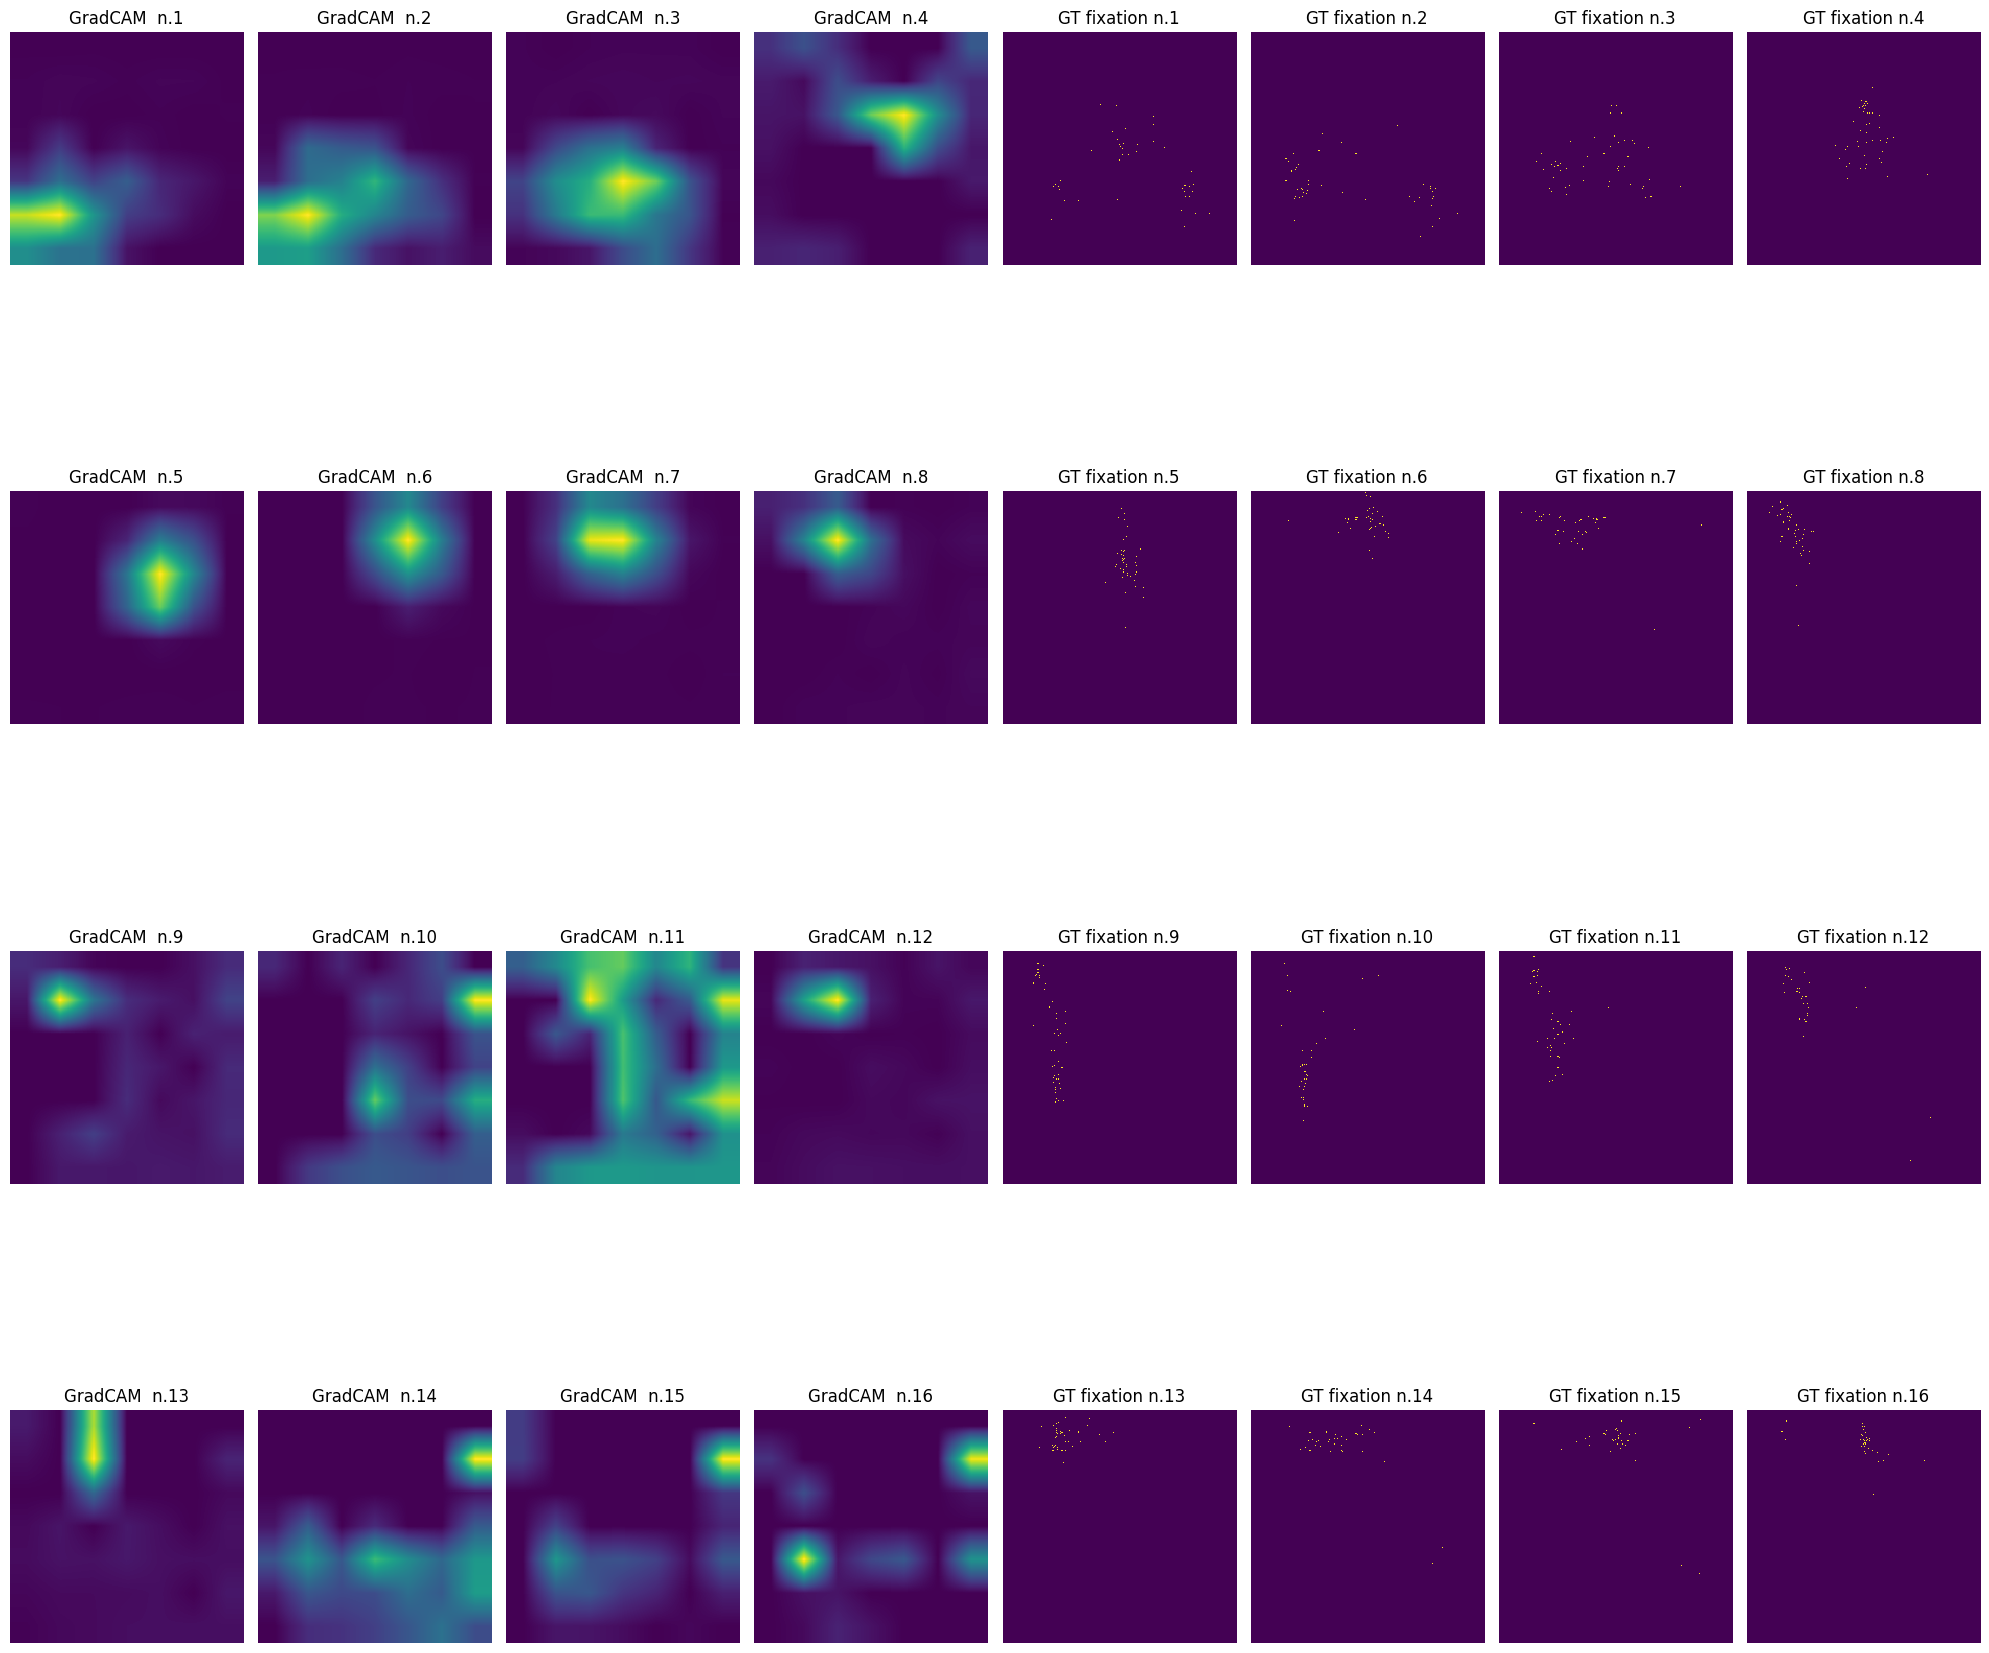

In [34]:
video='1_ab_WS_Help__r1__100'

#load the heatmap
temporal_Fixation_map = np.load(f'fixations/{video}/temporal_Fixation_map.npy')
#load the gradcam
normalized_heatmap = np.load(f'gradcams/{video}_gradCAMs.npy')

gt = [temporal_Fixation_map[:, :, i] for i in range(16)]
s_map = [normalized_heatmap[:, :, i] for i in range(16)]

#for all the gt if it is 0 keep it 0, otherwise set it to 1
for i in range(len(gt)):
    gt[i][gt[i] > 0] = 1
gt_distribution = []
for i in range(len(gt)):
    distr= gaussian_filter(gt[i], sigma=2.3)
    #normalize the distribution
    norm_distr = distr / np.sum(distr)
    gt_distribution.append(norm_distr)


#for each of the 16 frames, compute the metrics
AUC_Judd_list = []
NSS_list = []
CC_list = []
KLdiv_list= []

for i in range(16):
    AUC_Judd_list.append(AUC_Judd(s_map[i], gt[i]))
    NSS_list.append(NSS(s_map[i], gt[i]))
    CC_list.append(CC(s_map[i], gt[i]))
    KLdiv_list.append(KLdiv(s_map[i], gt[i]))


fig, axs = plt.subplots(4, 8, figsize=(20, 20))
for i in range(4):
    for j in range(4):
        #plot the saiency
        axs[i, j].imshow(s_map[i * 4 + j], cmap='viridis', interpolation='nearest')
        #plot in the nect slot the gt
        axs[i, j + 4].imshow(gt[i * 4 + j], cmap='viridis', interpolation='nearest')
        axs[i, j].set_title(f'GradCAM  n.{i * 4 + j+1}')
        axs[i, j + 4].set_title(f'GT fixation n.{i * 4 + j+1}')
        axs[i, j].axis('off')
        axs[i, j + 4].axis('off')
plt.tight_layout()

#compute and print the average of the metrics
print('Average AUC Judd:', np.mean(AUC_Judd_list))
print('Average NSS:', np.mean(NSS_list))
print('Average CC:', np.mean(CC_list))
print('Average KLdiv:', np.mean(KLdiv_list))


#max value of the metrics
print('Max AUC Judd:', np.max(AUC_Judd_list))
print('Max NSS:', np.max(NSS_list))
print('Max CC:', np.max(CC_list))
print('Min KLdiv:', np.min(KLdiv_list))

Text(0.5, 1.0, 'KLdiv')

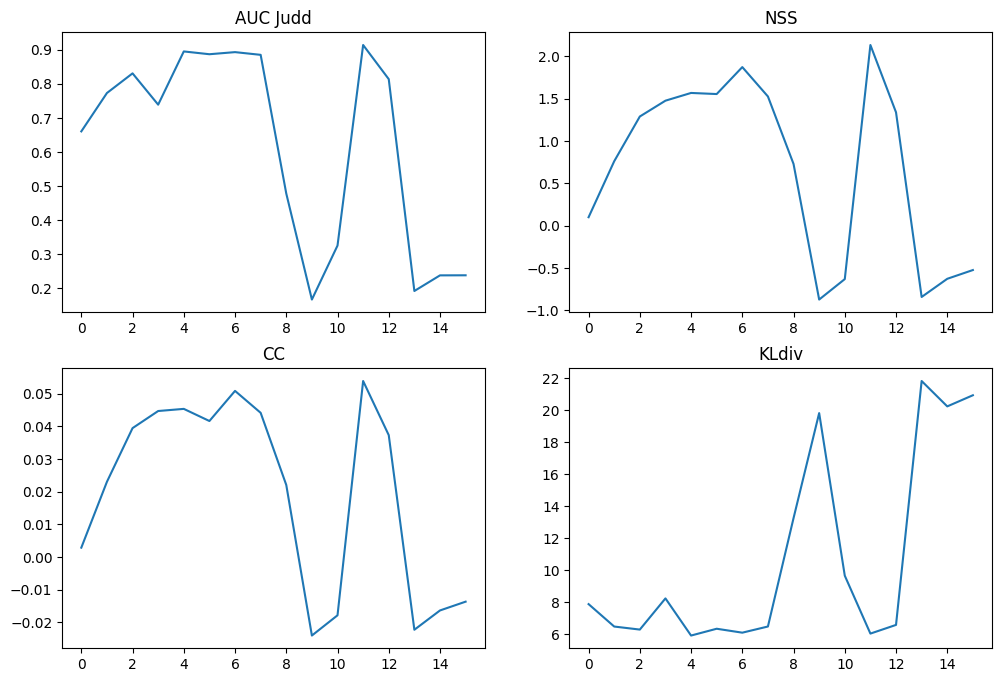

In [35]:
# Plot the metrics
fig, axs = plt.subplots(2, 2, figsize=(12, 8))
axs[0, 0].plot(AUC_Judd_list)
axs[0, 0].set_title('AUC Judd')
axs[0, 1].plot(NSS_list)
axs[0, 1].set_title('NSS')
axs[1, 0].plot(CC_list)
axs[1, 0].set_title('CC')
axs[1, 1].plot(KLdiv_list)
axs[1, 1].set_title('KLdiv')

In [222]:
def temporal_metrics(video_name):

    #load the heatmap
    temporal_Fixation_map = np.load(f'fixations/{video_name}/temporal_Fixation_map.npy')
    #load the gradcam
    normalized_heatmap = np.load(f'gradcams/{video_name}_gradCAMs.npy')

    gt = [temporal_Fixation_map[:, :, i] for i in range(16)]
    s_map = [normalized_heatmap[:, :, i] for i in range(16)]

    #for all the gt if it is 0 keep it 0, otherwise set it to 1
    for i in range(len(gt)):
        gt[i][gt[i] > 0] = 1
    gt_distribution = []
    for i in range(len(gt)):
        distr= gaussian_filter(gt[i], sigma=2.3)
        #normalize the distribution
        norm_distr = distr / np.sum(distr)
        gt_distribution.append(norm_distr)


    #for each of the 16 frames, compute the metrics
    AUC_Judd_list = []
    NSS_list = []
    CC_list = []
    KLdiv_list= []

    for i in range(16):
        AUC_Judd_list.append(AUC_Judd(s_map[i], gt[i]))
        NSS_list.append(NSS(s_map[i], gt[i]))
        CC_list.append(CC(s_map[i], gt_distribution[i]))
        KLdiv_list.append(KLdiv(s_map[i], gt_distribution[i]))

    return AUC_Judd_list, NSS_list, CC_list, KLdiv_list

In [ ]:
metrics_dict = {}

for video in gaze_videos:
    AUC_Judd_list, NSS_list, CC_list, KLdiv_list = temporal_metrics(video)
    metrics_dict[video] = {
        'AUC_Judd': AUC_Judd_list,
        'NSS': NSS_list,
        'CC': CC_list,
        'KLdiv': KLdiv_list
    }

In [195]:
#instead of what done previously in temporal metrics now let's compute the metrics on the summed heatmap
def total_metrics(video_name, model_name, network_type='CNN'):

    #load the heatmap
    temporal_Fixation_map = np.load(f'fixations/{video_name}/temporal_Fixation_map.npy')

    gt = [temporal_Fixation_map[:, :, i] for i in range(16)]

    

    if network_type== 'CNN':
        normalized_heatmap = np.load(f'gradcams/{model_name}/{video_name}_gradCAMs.npy')
        s_map = [normalized_heatmap[:, :, i] for i in range(16)]  
    elif network_type == 'Transformer':
        normalized_heatmap = np.load(f'gradcams/{model_name}/{video_name}_attn_mean.npy')
        s_map = [normalized_heatmap[i, :, :] for i in range(16)]
    else:
        raise ValueError("type must be either 'CNN' or 'Transformer'")

    #sum the heatmaps

    overall_s_map = np.sum(s_map, axis=0)
    #s_map shape in the three dimension one by one
    #print("s_map first dimensoin shape:", s_map[0].shape, "second dimension shape:", s_map[1].shape, "third dimension shape:", s_map[2].shape, "fourth dimension shape:", s_map[3].shape, "... last dimension shape:", s_map[15].shape, "and it is number of frames:", len(s_map))
    #print("Overall heatmap shape:", overall_s_map.shape)
    overall_gt = np.sum(gt, axis=0)
    #print("gt first dimensoin shape:", gt[0].shape, "second dimension shape:", gt[1].shape, "third dimension shape:", gt[2].shape, "fourth dimension shape:", gt[3].shape, "... last dimension shape:", gt[15].shape, "and it is number of frames:", len(gt))
    #print("Overall ground truth shape:", overall_gt.shape)

    #normalize the overall heatmap
    overall_s_map = overall_s_map / np.sum(overall_s_map)
    #if it is 0 keep it 0, otherwise set it to 1
    overall_gt[overall_gt > 0] = 1
    #apply a gaussian filter to the overall ground truth
    overall_gt_distribution = gaussian_filter(overall_gt, sigma=2.3)
    overall_gt_distribution = overall_gt_distribution / np.sum(overall_gt_distribution)


    #compute the metrics
    AUC_Judd_val = AUC_Judd(overall_s_map, overall_gt)
    NSS_val = NSS(overall_s_map, overall_gt)
    CC_val = CC(overall_s_map, overall_gt_distribution)
    KLdiv_val = KLdiv(overall_s_map, overall_gt_distribution)

    return AUC_Judd_val, NSS_val, CC_val, KLdiv_val

In [199]:
for video in gaze_videos:
    AUC_Judd_value, NSS_value, CC_value, KLdiv_value = total_metrics(video, 'TSM')
    metrics_dict[video] = {
        'AUC_Judd': AUC_Judd_value,
        'NSS': NSS_value,
        'CC': CC_value,
        'KLdiv': KLdiv_value
    }

# print the average, the std deviation of the AUC_Judd, NSS, CC, KLdiv
avg_AUC_Judd = np.mean([metrics['AUC_Judd'] for metrics in metrics_dict.values()])
avg_NSS = np.mean([metrics['NSS'] for metrics in metrics_dict.values()])
avg_CC = np.mean([metrics['CC'] for metrics in metrics_dict.values()])
avg_KLdiv = np.mean([metrics['KLdiv'] for metrics in metrics_dict.values()])
std_AUC_Judd = np.std([metrics['AUC_Judd'] for metrics in metrics_dict.values()])
std_NSS = np.std([metrics['NSS'] for metrics in metrics_dict.values()])
std_CC = np.std([metrics['CC'] for metrics in metrics_dict.values()])
std_KLdiv = np.std([metrics['KLdiv'] for metrics in metrics_dict.values()])

#round to the second decimal
print('Average AUC Judd:', np.round(avg_AUC_Judd, 2), "+-" , np.round(std_AUC_Judd, 2))
print('Average NSS:', np.round(avg_NSS, 2), "+-" , np.round(std_NSS, 2))
print('Average CC:', np.round(avg_CC, 2), "+-" , np.round(std_CC, 2))
print('Average KLdiv:', np.round(avg_KLdiv, 2), "+-" , np.round(std_KLdiv, 2))

print("=================================================================================")
#now print avg e std dev of video that contains Help in their name
help_videos = [video for video in gaze_videos_complete if 'Help' in video]
avg_AUC_Judd_help = np.mean([metrics_dict[video]['AUC_Judd'] for video in help_videos])
avg_NSS_help = np.mean([metrics_dict[video]['NSS'] for video in help_videos])
avg_CC_help = np.mean([metrics_dict[video]['CC'] for video in help_videos])
avg_KLdiv_help = np.mean([metrics_dict[video]['KLdiv'] for video in help_videos])
std_AUC_Judd_help = np.std([metrics_dict[video]['AUC_Judd'] for video in help_videos])
std_NSS_help = np.std([metrics_dict[video]['NSS'] for video in help_videos])
std_CC_help = np.std([metrics_dict[video]['CC'] for video in help_videos])
std_KLdiv_help = np.std([metrics_dict[video]['KLdiv'] for video in help_videos])
print('Average AUC Judd Help:', np.round(avg_AUC_Judd_help, 2), "+-" , np.round(std_AUC_Judd_help, 2))
print('Average NSS Help:', np.round(avg_NSS_help, 2), "+-" , np.round(std_NSS_help, 2))
print('Average CC Help:', np.round(avg_CC_help, 2), "+-" , np.round(std_CC_help, 2))
print('Average KLdiv Help:', np.round(avg_KLdiv_help, 2), "+-" , np.round(std_KLdiv_help, 2))
    
print("=================================================================================")
#now print avg e std dev of video that contains Hinder in their name round to the second decimal
hinder_videos = [video for video in gaze_videos_complete if 'Hinder' in video]
avg_AUC_Judd_hinder = np.mean([metrics_dict[video]['AUC_Judd'] for video in hinder_videos])
avg_NSS_hinder = np.mean([metrics_dict[video]['NSS'] for video in hinder_videos])
avg_CC_hinder = np.mean([metrics_dict[video]['CC'] for video in hinder_videos])
avg_KLdiv_hinder = np.mean([metrics_dict[video]['KLdiv'] for video in hinder_videos])
std_AUC_Judd_hinder = np.std([metrics_dict[video]['AUC_Judd'] for video in hinder_videos])
std_NSS_hinder = np.std([metrics_dict[video]['NSS'] for video in hinder_videos])
std_CC_hinder = np.std([metrics_dict[video]['CC'] for video in hinder_videos])
std_KLdiv_hinder = np.std([metrics_dict[video]['KLdiv'] for video in hinder_videos])
print('Average AUC Judd Hinder:', np.round(avg_AUC_Judd_hinder, 2), "+-" , np.round(std_AUC_Judd_hinder, 2))
print('Average NSS Hinder:', np.round(avg_NSS_hinder, 2), "+-" , np.round(std_NSS_hinder, 2))
print('Average CC Hinder:', np.round(avg_CC_hinder, 2), "+-" , np.round(std_CC_hinder, 2))
print('Average KLdiv Hinder:', np.round(avg_KLdiv_hinder, 2), "+-" , np.round(std_KLdiv_hinder, 2))

print("=================================================================================")
#now print avg e std dev of video that contains Physical in their name
physical_videos = [video for video in gaze_videos_complete if 'Physical' in video]
avg_AUC_Judd_physical = np.mean([metrics_dict[video]['AUC_Judd'] for video in physical_videos])
avg_NSS_physical = np.mean([metrics_dict[video]['NSS'] for video in physical_videos])
avg_CC_physical = np.mean([metrics_dict[video]['CC'] for video in physical_videos])
avg_KLdiv_physical = np.mean([metrics_dict[video]['KLdiv'] for video in physical_videos])
std_AUC_Judd_physical = np.std([metrics_dict[video]['AUC_Judd'] for video in physical_videos])
std_NSS_physical = np.std([metrics_dict[video]['NSS'] for video in physical_videos])
std_CC_physical = np.std([metrics_dict[video]['CC'] for video in physical_videos])
std_KLdiv_physical = np.std([metrics_dict[video]['KLdiv'] for video in physical_videos])
print('Average AUC Judd Physical:', np.round(avg_AUC_Judd_physical, 2), "+-" , np.round(std_AUC_Judd_physical, 2))
print('Average NSS Physical:', np.round(avg_NSS_physical, 2), "+-" , np.round(std_NSS_physical, 2))
print('Average CC Physical:', np.round(avg_CC_physical, 2), "+-" , np.round(std_CC_physical, 2))
print('Average KLdiv Physical:', np.round(avg_KLdiv_physical, 2), "+-" , np.round(std_KLdiv_physical, 2))

Average AUC Judd: 0.65 +- 0.08
Average NSS: 0.53 +- 0.34
Average CC: 0.22 +- 0.15
Average KLdiv: 1.53 +- 0.35
Average AUC Judd Help: 0.61 +- 0.1
Average NSS Help: 0.4 +- 0.33
Average CC Help: 0.16 +- 0.14
Average KLdiv Help: 1.72 +- 0.41
Average AUC Judd Hinder: 0.69 +- 0.06
Average NSS Hinder: 0.76 +- 0.31
Average CC Hinder: 0.34 +- 0.14
Average KLdiv Hinder: 1.28 +- 0.31
Average AUC Judd Physical: 0.64 +- 0.07
Average NSS Physical: 0.47 +- 0.28
Average CC Physical: 0.18 +- 0.1
Average KLdiv Physical: 1.53 +- 0.12


# COMPARISON

In [128]:
""" for raw data of GRADCAM """

def parse_heatmap_file(file_name):
    #open the file
    with open(file_name, 'r') as file:
        lines = file.readlines()

    frame_data = {}
    current_frame = None

    #analyze the row of the file
    for line in lines:
        if line.startswith("Frame"):  # find the beginning of the values of one frame
            current_frame = int(line.split()[1]) - 1
            frame_data[current_frame] = []  # a list for the file of this frame
        elif "Heatmap values:" in line:
            continue  # Skip the line that contains "Heatmap values:"
        else:  # line with values
            values = list(map(float, line.split()))
            frame_data[current_frame].extend(values)

    # create a dataframe with collected data
    df = pd.DataFrame.from_dict(frame_data, orient='index')

    # rename the row of the DataFrame with "Frame {n}"
    df.index = [f"Frame {i}" for i in range(len(frame_data))]

    return df

# function that sum and normalize data
def process_heatmap_data(df):
    #for each of the 16 frame, normalize the heatmap
    df = df.div(df.max(axis=1), axis=0)

    #return a 16 x 224 x 224 matrix

    heatmap_2d = np.zeros((224, 224, 16))
    for i in range(16):
        heatmap_2d[:, :, i] = df.iloc[i].values.reshape(224, 224)

    return heatmap_2d

#let's have a look to all the heatmaps
#visualize in a heatmap all the
for video in gaze_videos:
    file_name = f'gradcams/TANet/{video}_grad.txt'
    df = parse_heatmap_file(file_name)

    # Somma e normalizzazione
    normalized_heatmap = process_heatmap_data(df)

    #save the heatmap in a folder
    np.save(f'gradcams/TANet/{video}_gradCAMs.npy', normalized_heatmap)

    #to be done for each model

In [126]:
""" for raw data of fixation"""

#for all tsv in notebook_data folder create an heatmap and sum them all
for video in gaze_videos:
    temporal_Fixation_map = np.zeros((224, 224,16))
    for i in range(1, 10):
        df_humans = pd.read_csv(f'fixations/{video}/subject_{i}.tsv', sep='\t')
        time_0= df_humans['Recording timestamp'].iloc[0]
        time_final=df_humans['Recording timestamp'].iloc[-1]
        for index, row in df_humans.iterrows():
            x = int(row['Fixation point X'])
            y = int(row['Fixation point Y'])
            timestamp=int(row['Recording timestamp'])

            window=int((timestamp-time_0)/((time_final-time_0)/16))

            if x >= 0 and x < 224 and y >= 0 and y < 224 and window<16:
                temporal_Fixation_map[y, x, window] += 1

    #save temporal_Fixation_map as npy file
    np.save(f'fixations/{video}/temporal_Fixation_map.npy', temporal_Fixation_map)

# Comparison for a single video of the models

In [ ]:
#to be changed for single videos analyses
video='1_bc_WS_Hinder__r3__100'

# TSM

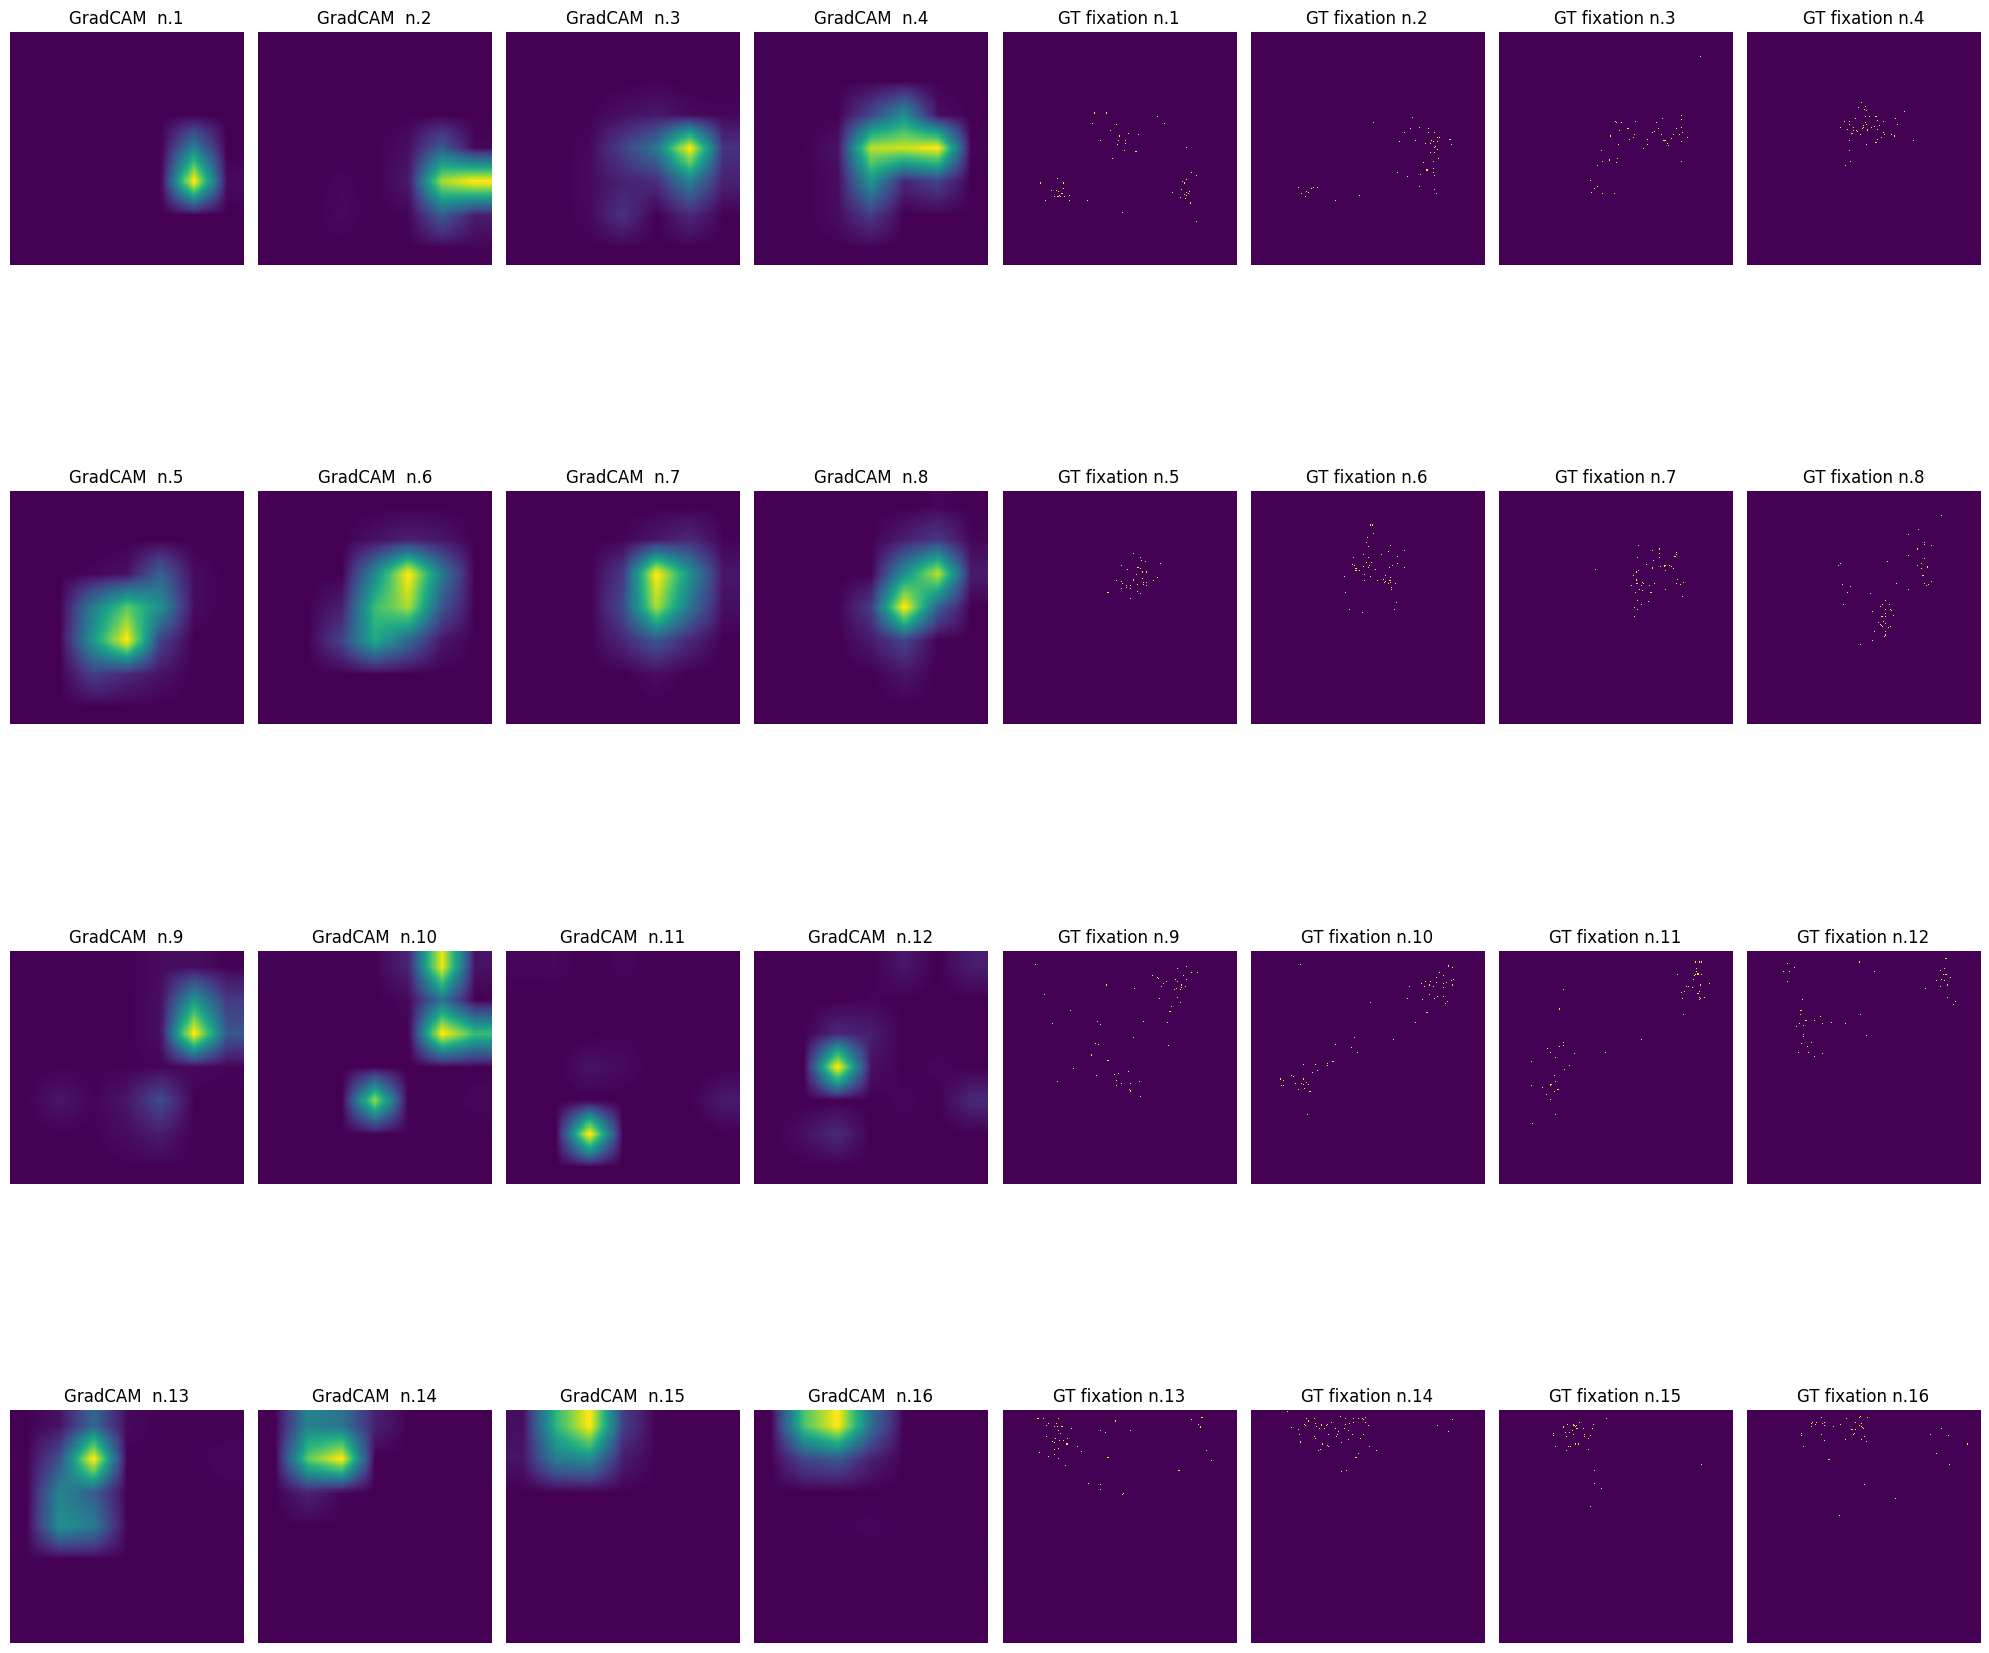

Average AUC Judd: 0.798720398412738
Average NSS: 1.4885536930416823
Average CC: 0.046393451729576776
Average KLdiv: 7.402717501461852
Max AUC Judd: 0.9595374309324727
Max NSS: 3.6729738090130724
Max CC: 0.1011174541618261
Min KLdiv: 4.971732495729672


Text(0.5, 1.0, 'KLdiv')

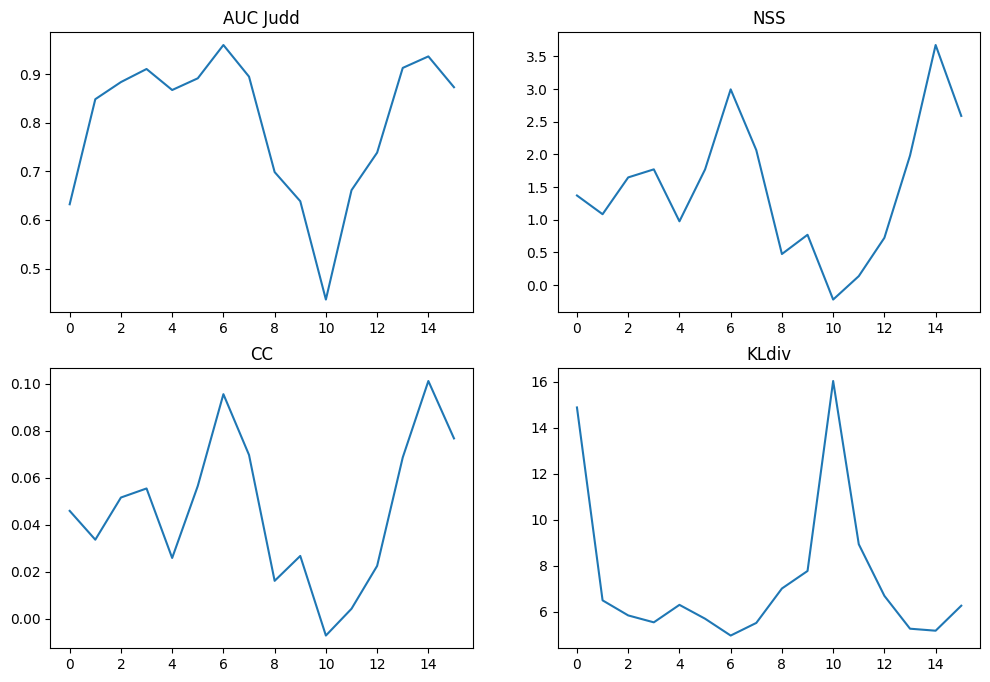

In [25]:
#load the heatmap
temporal_Fixation_map = np.load(f'fixations/{video}/temporal_Fixation_map.npy')
#load the gradcam
normalized_heatmap = np.load(f'gradcams/TSM/{video}_gradCAMs.npy')

gt = [temporal_Fixation_map[:, :, i] for i in range(16)]
s_map = [normalized_heatmap[:, :, i] for i in range(16)]

#for all the gt if it is 0 keep it 0, otherwise set it to 1
for i in range(len(gt)):
    gt[i][gt[i] > 0] = 1
gt_distribution = []
for i in range(len(gt)):
    distr= gaussian_filter(gt[i], sigma=2.3)
    #normalize the distribution
    norm_distr = distr / np.sum(distr)
    gt_distribution.append(norm_distr)


#for each of the 16 frames, compute the metrics
AUC_Judd_list = []
NSS_list = []
CC_list = []
KLdiv_list= []

for i in range(16):
    AUC_Judd_list.append(AUC_Judd(s_map[i], gt[i]))
    NSS_list.append(NSS(s_map[i], gt[i]))
    CC_list.append(CC(s_map[i], gt[i]))
    KLdiv_list.append(KLdiv(s_map[i], gt[i]))


fig, axs = plt.subplots(4, 8, figsize=(20, 20))
for i in range(4):
    for j in range(4):
        #plot the saiency
        axs[i, j].imshow(s_map[i * 4 + j], cmap='viridis', interpolation='nearest')
        #plot in the nect slot the gt
        axs[i, j + 4].imshow(gt[i * 4 + j], cmap='viridis', interpolation='nearest')
        axs[i, j].set_title(f'GradCAM  n.{i * 4 + j+1}')
        axs[i, j + 4].set_title(f'GT fixation n.{i * 4 + j+1}')
        axs[i, j].axis('off')
        axs[i, j + 4].axis('off')
plt.tight_layout()
plt.show()

#compute and print the average of the metrics
print('Average AUC Judd:', np.mean(AUC_Judd_list))
print('Average NSS:', np.mean(NSS_list))
print('Average CC:', np.mean(CC_list))
print('Average KLdiv:', np.mean(KLdiv_list))


#max value of the metrics
print('Max AUC Judd:', np.max(AUC_Judd_list))
print('Max NSS:', np.max(NSS_list))
print('Max CC:', np.max(CC_list))
print('Min KLdiv:', np.min(KLdiv_list))

fig, axs = plt.subplots(2, 2, figsize=(12, 8))
axs[0, 0].plot(AUC_Judd_list)
axs[0, 0].set_title('AUC Judd')
axs[0, 1].plot(NSS_list)
axs[0, 1].set_title('NSS')
axs[1, 0].plot(CC_list)
axs[1, 0].set_title('CC')
axs[1, 1].plot(KLdiv_list)
axs[1, 1].set_title('KLdiv')

# TSN

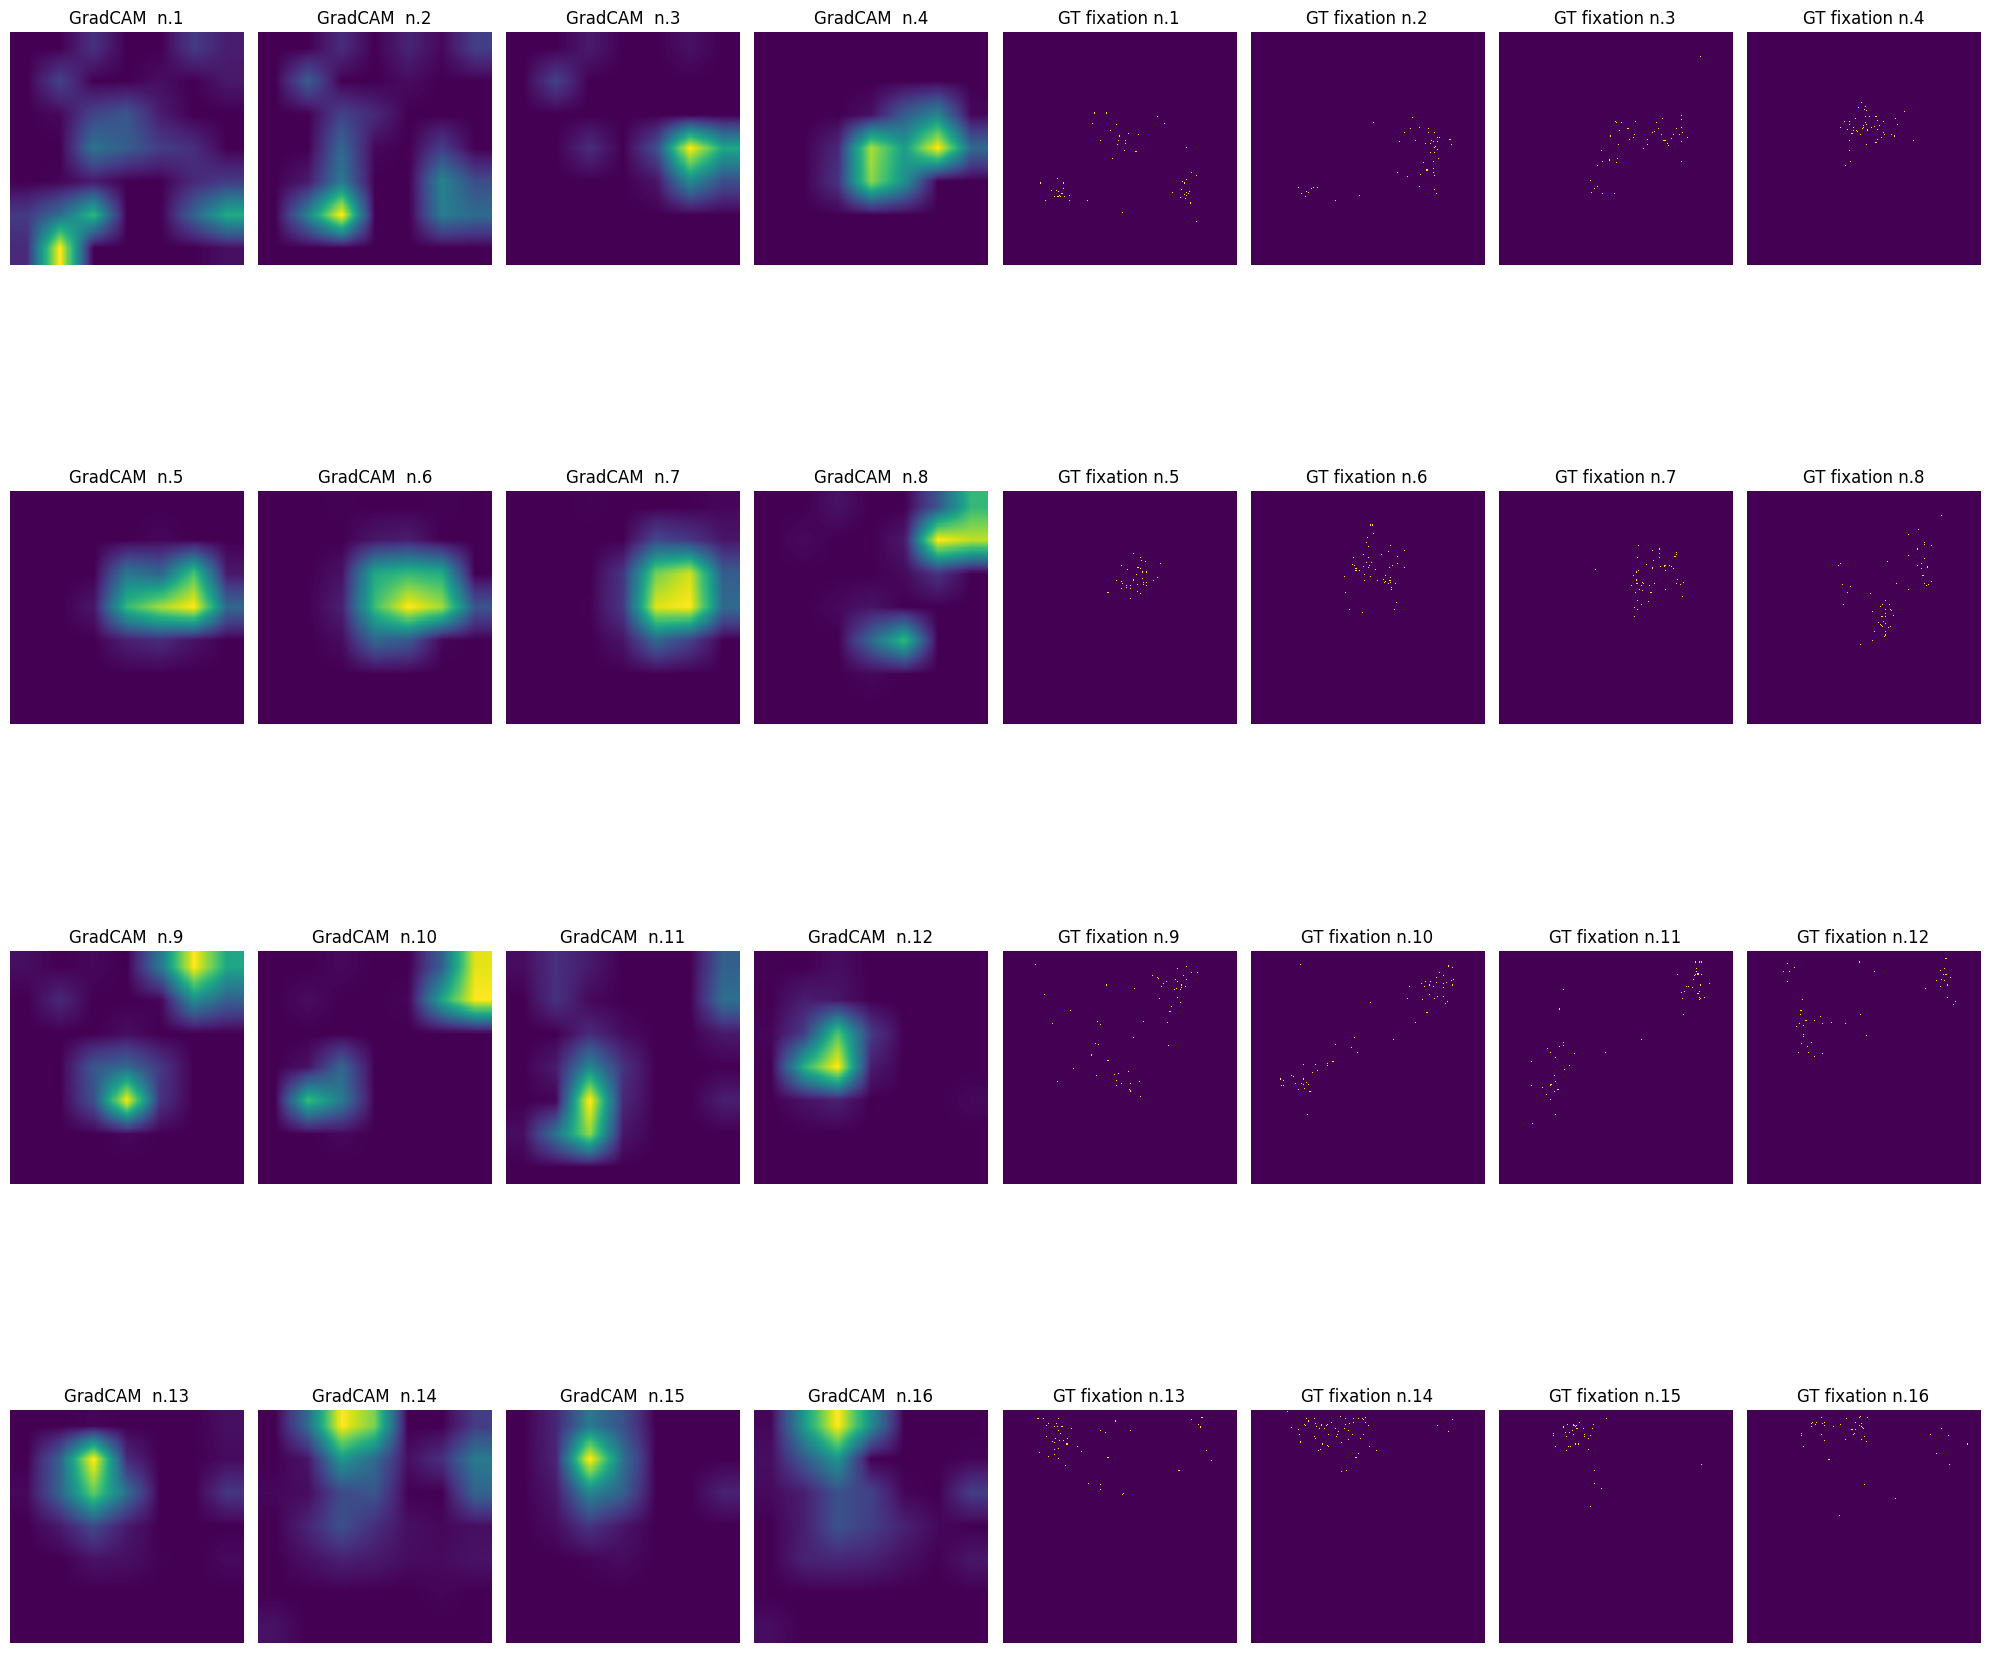

Average AUC Judd: 0.8262760751638537
Average NSS: 1.3175355309943095
Average CC: 0.04127017983588712
Average KLdiv: 6.759812242362798
Max AUC Judd: 0.941180793891505
Max NSS: 2.77718611180492
Max CC: 0.09609314548223798
Min KLdiv: 5.206773138210078


Text(0.5, 1.0, 'KLdiv')

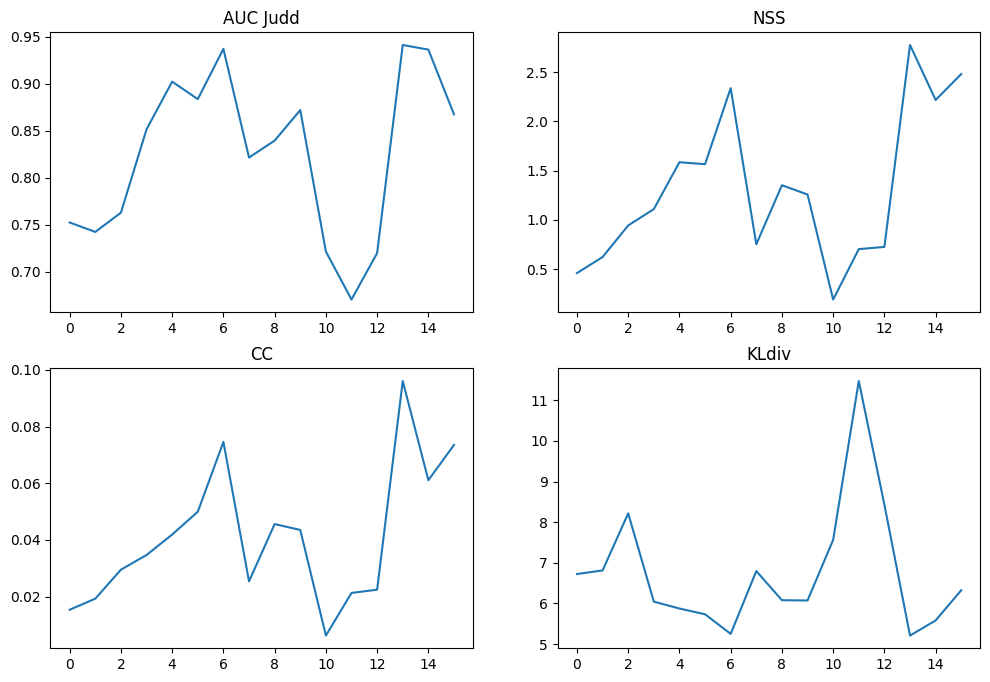

In [26]:
#load the heatmap
temporal_Fixation_map = np.load(f'fixations/{video}/temporal_Fixation_map.npy')
#load the gradcam
normalized_heatmap = np.load(f'gradcams/TSN/{video}_gradCAMs.npy')

gt = [temporal_Fixation_map[:, :, i] for i in range(16)]
s_map = [normalized_heatmap[:, :, i] for i in range(16)]

#for all the gt if it is 0 keep it 0, otherwise set it to 1
for i in range(len(gt)):
    gt[i][gt[i] > 0] = 1
gt_distribution = []
for i in range(len(gt)):
    distr= gaussian_filter(gt[i], sigma=2.3)
    #normalize the distribution
    norm_distr = distr / np.sum(distr)
    gt_distribution.append(norm_distr)


#for each of the 16 frames, compute the metrics
AUC_Judd_list = []
NSS_list = []
CC_list = []
KLdiv_list= []

for i in range(16):
    AUC_Judd_list.append(AUC_Judd(s_map[i], gt[i]))
    NSS_list.append(NSS(s_map[i], gt[i]))
    CC_list.append(CC(s_map[i], gt[i]))
    KLdiv_list.append(KLdiv(s_map[i], gt[i]))


fig, axs = plt.subplots(4, 8, figsize=(20, 20))
for i in range(4):
    for j in range(4):
        #plot the saiency
        axs[i, j].imshow(s_map[i * 4 + j], cmap='viridis', interpolation='nearest')
        #plot in the nect slot the gt
        axs[i, j + 4].imshow(gt[i * 4 + j], cmap='viridis', interpolation='nearest')
        axs[i, j].set_title(f'GradCAM  n.{i * 4 + j+1}')
        axs[i, j + 4].set_title(f'GT fixation n.{i * 4 + j+1}')
        axs[i, j].axis('off')
        axs[i, j + 4].axis('off')
plt.tight_layout()
plt.show()

#compute and print the average of the metrics
print('Average AUC Judd:', np.mean(AUC_Judd_list))
print('Average NSS:', np.mean(NSS_list))
print('Average CC:', np.mean(CC_list))
print('Average KLdiv:', np.mean(KLdiv_list))


#max value of the metrics
print('Max AUC Judd:', np.max(AUC_Judd_list))
print('Max NSS:', np.max(NSS_list))
print('Max CC:', np.max(CC_list))
print('Min KLdiv:', np.min(KLdiv_list))

fig, axs = plt.subplots(2, 2, figsize=(12, 8))
axs[0, 0].plot(AUC_Judd_list)
axs[0, 0].set_title('AUC Judd')
axs[0, 1].plot(NSS_list)
axs[0, 1].set_title('NSS')
axs[1, 0].plot(CC_list)
axs[1, 0].set_title('CC')
axs[1, 1].plot(KLdiv_list)
axs[1, 1].set_title('KLdiv')

## TIMESFORMER

Data shape: (16, 224, 224)
s_map shape (224, 224)


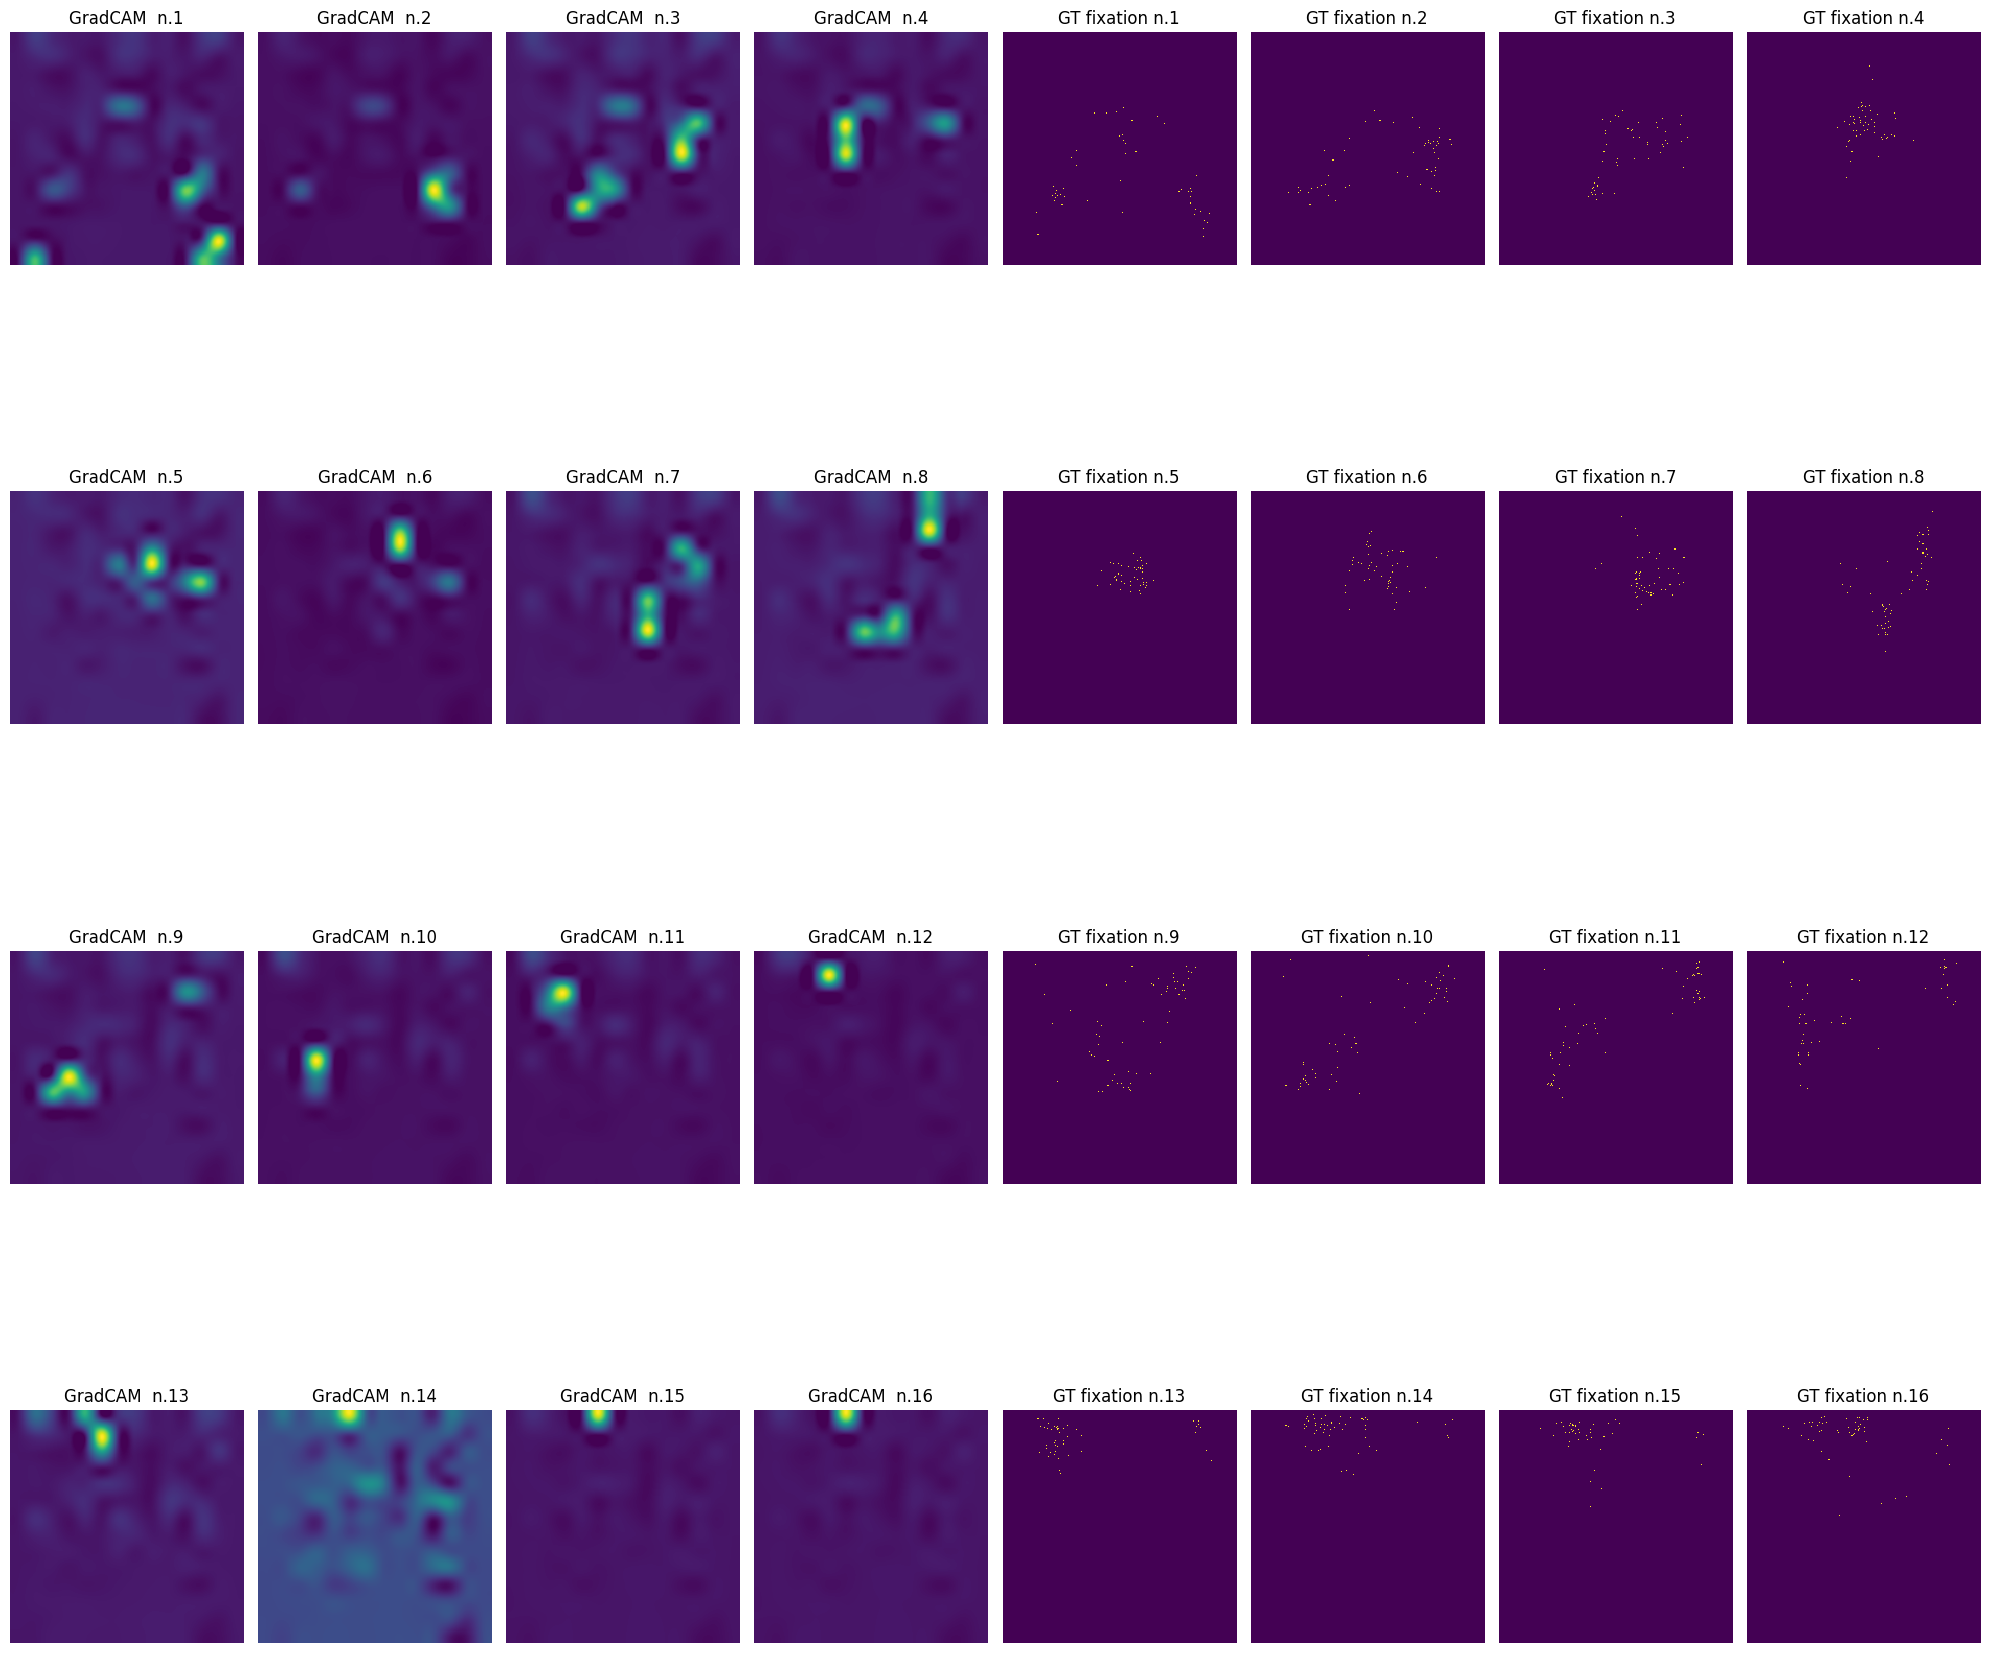

Average AUC Judd: 0.6307928982252304
Average NSS: 0.9008803129272354
Average CC: 0.02907209475890496
Average KLdiv: 7.4244800771989
Max AUC Judd: 0.9347307869105544
Max NSS: 2.8760390860887353
Max CC: 0.0871214003497207
Min KLdiv: 6.037729358585529


Text(0.5, 1.0, 'KLdiv')

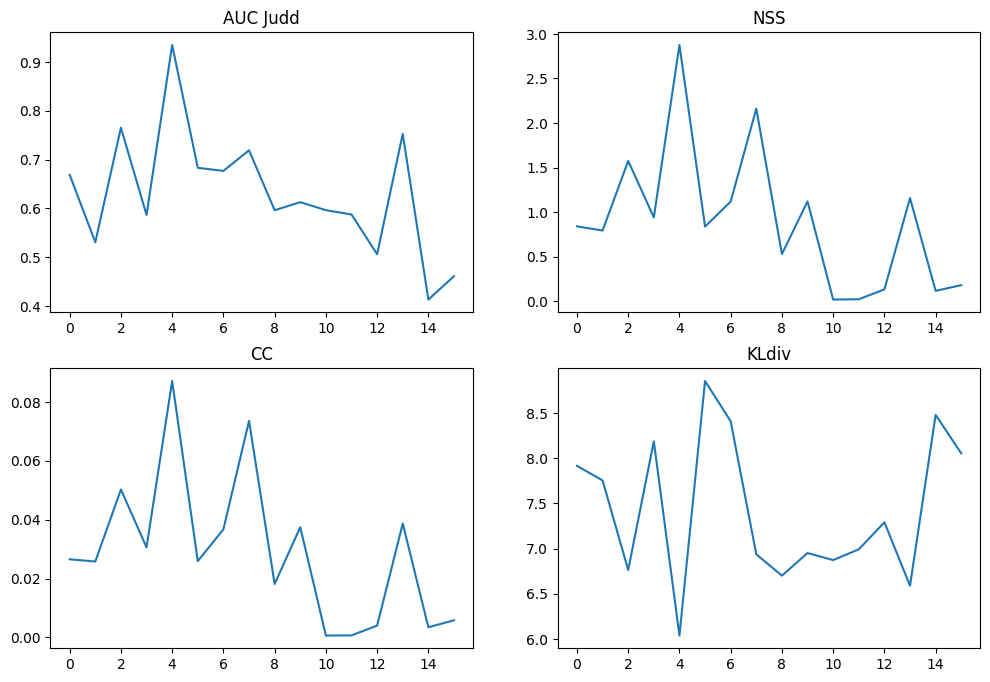

In [61]:
#load the data and then take the 16 frames and create an overall map
data = np.load(f'gradcams/balanced/timesformer/{video}_attn_mean.npy')

# Check the shape of the data
print("Data shape:", data.shape)  # Should be (16, 700, 700)
# Create a 16 x 224 x 224 matrix
heatmap_2d = np.zeros((16, 224, 224))

for i in range(16):
    heatmap_2d [i,:,:] = data[i,:,:] #interpolazione bicubica: media pesata dei 16 pixel circondanti

#CONTROLL LINE: if heatmap value is below 0 set it to 0
heatmap_2d[heatmap_2d < 0] = 0

#load the heatmap
temporal_Fixation_map = np.load(f'fixations/{video}/temporal_Fixation_map.npy')
#load the gradcam
normalized_heatmap = heatmap_2d

gt = [temporal_Fixation_map[:, :, i] for i in range(16)]
s_map = [normalized_heatmap[i, :, :] for i in range(16)]

#for all the gt if it is 0 keep it 0, otherwise set it to 1
for i in range(len(gt)):
    gt[i][gt[i] > 0] = 1
gt_distribution = []
for i in range(len(gt)):
    distr= gaussian_filter(gt[i], sigma=2.3)
    #normalize the distribution
    norm_distr = distr / np.sum(distr)
    gt_distribution.append(norm_distr)


#for each of the 16 frames, compute the metrics
AUC_Judd_list = []
NSS_list = []
CC_list = []
KLdiv_list= []

print("s_map shape", s_map[0].shape)

for i in range(16):
    AUC_Judd_list.append(AUC_Judd(s_map[i], gt[i]))
    NSS_list.append(NSS(s_map[i], gt[i]))
    CC_list.append(CC(s_map[i], gt[i]))
    KLdiv_list.append(KLdiv(s_map[i], gt[i]))


fig, axs = plt.subplots(4, 8, figsize=(20, 20))
for i in range(4):
    for j in range(4):
        #plot the saiency
        axs[i, j].imshow(s_map[i * 4 + j], cmap='viridis', interpolation='nearest')
        #plot in the nect slot the gt
        axs[i, j + 4].imshow(gt[i * 4 + j], cmap='viridis', interpolation='nearest')
        axs[i, j].set_title(f'GradCAM  n.{i * 4 + j+1}')
        axs[i, j + 4].set_title(f'GT fixation n.{i * 4 + j+1}')
        axs[i, j].axis('off')
        axs[i, j + 4].axis('off')
plt.tight_layout()
plt.show()

#compute and print the average of the metrics
print('Average AUC Judd:', np.mean(AUC_Judd_list))
print('Average NSS:', np.mean(NSS_list))
print('Average CC:', np.mean(CC_list))
print('Average KLdiv:', np.mean(KLdiv_list))


#max value of the metrics
print('Max AUC Judd:', np.max(AUC_Judd_list))
print('Max NSS:', np.max(NSS_list))
print('Max CC:', np.max(CC_list))
print('Min KLdiv:', np.min(KLdiv_list))

fig, axs = plt.subplots(2, 2, figsize=(12, 8))
axs[0, 0].plot(AUC_Judd_list)
axs[0, 0].set_title('AUC Judd')
axs[0, 1].plot(NSS_list)
axs[0, 1].set_title('NSS')
axs[1, 0].plot(CC_list)
axs[1, 0].set_title('CC')
axs[1, 1].plot(KLdiv_list)
axs[1, 1].set_title('KLdiv')

## ViVIT

Data shape: (16, 700, 700)
s_map shape (224, 224)


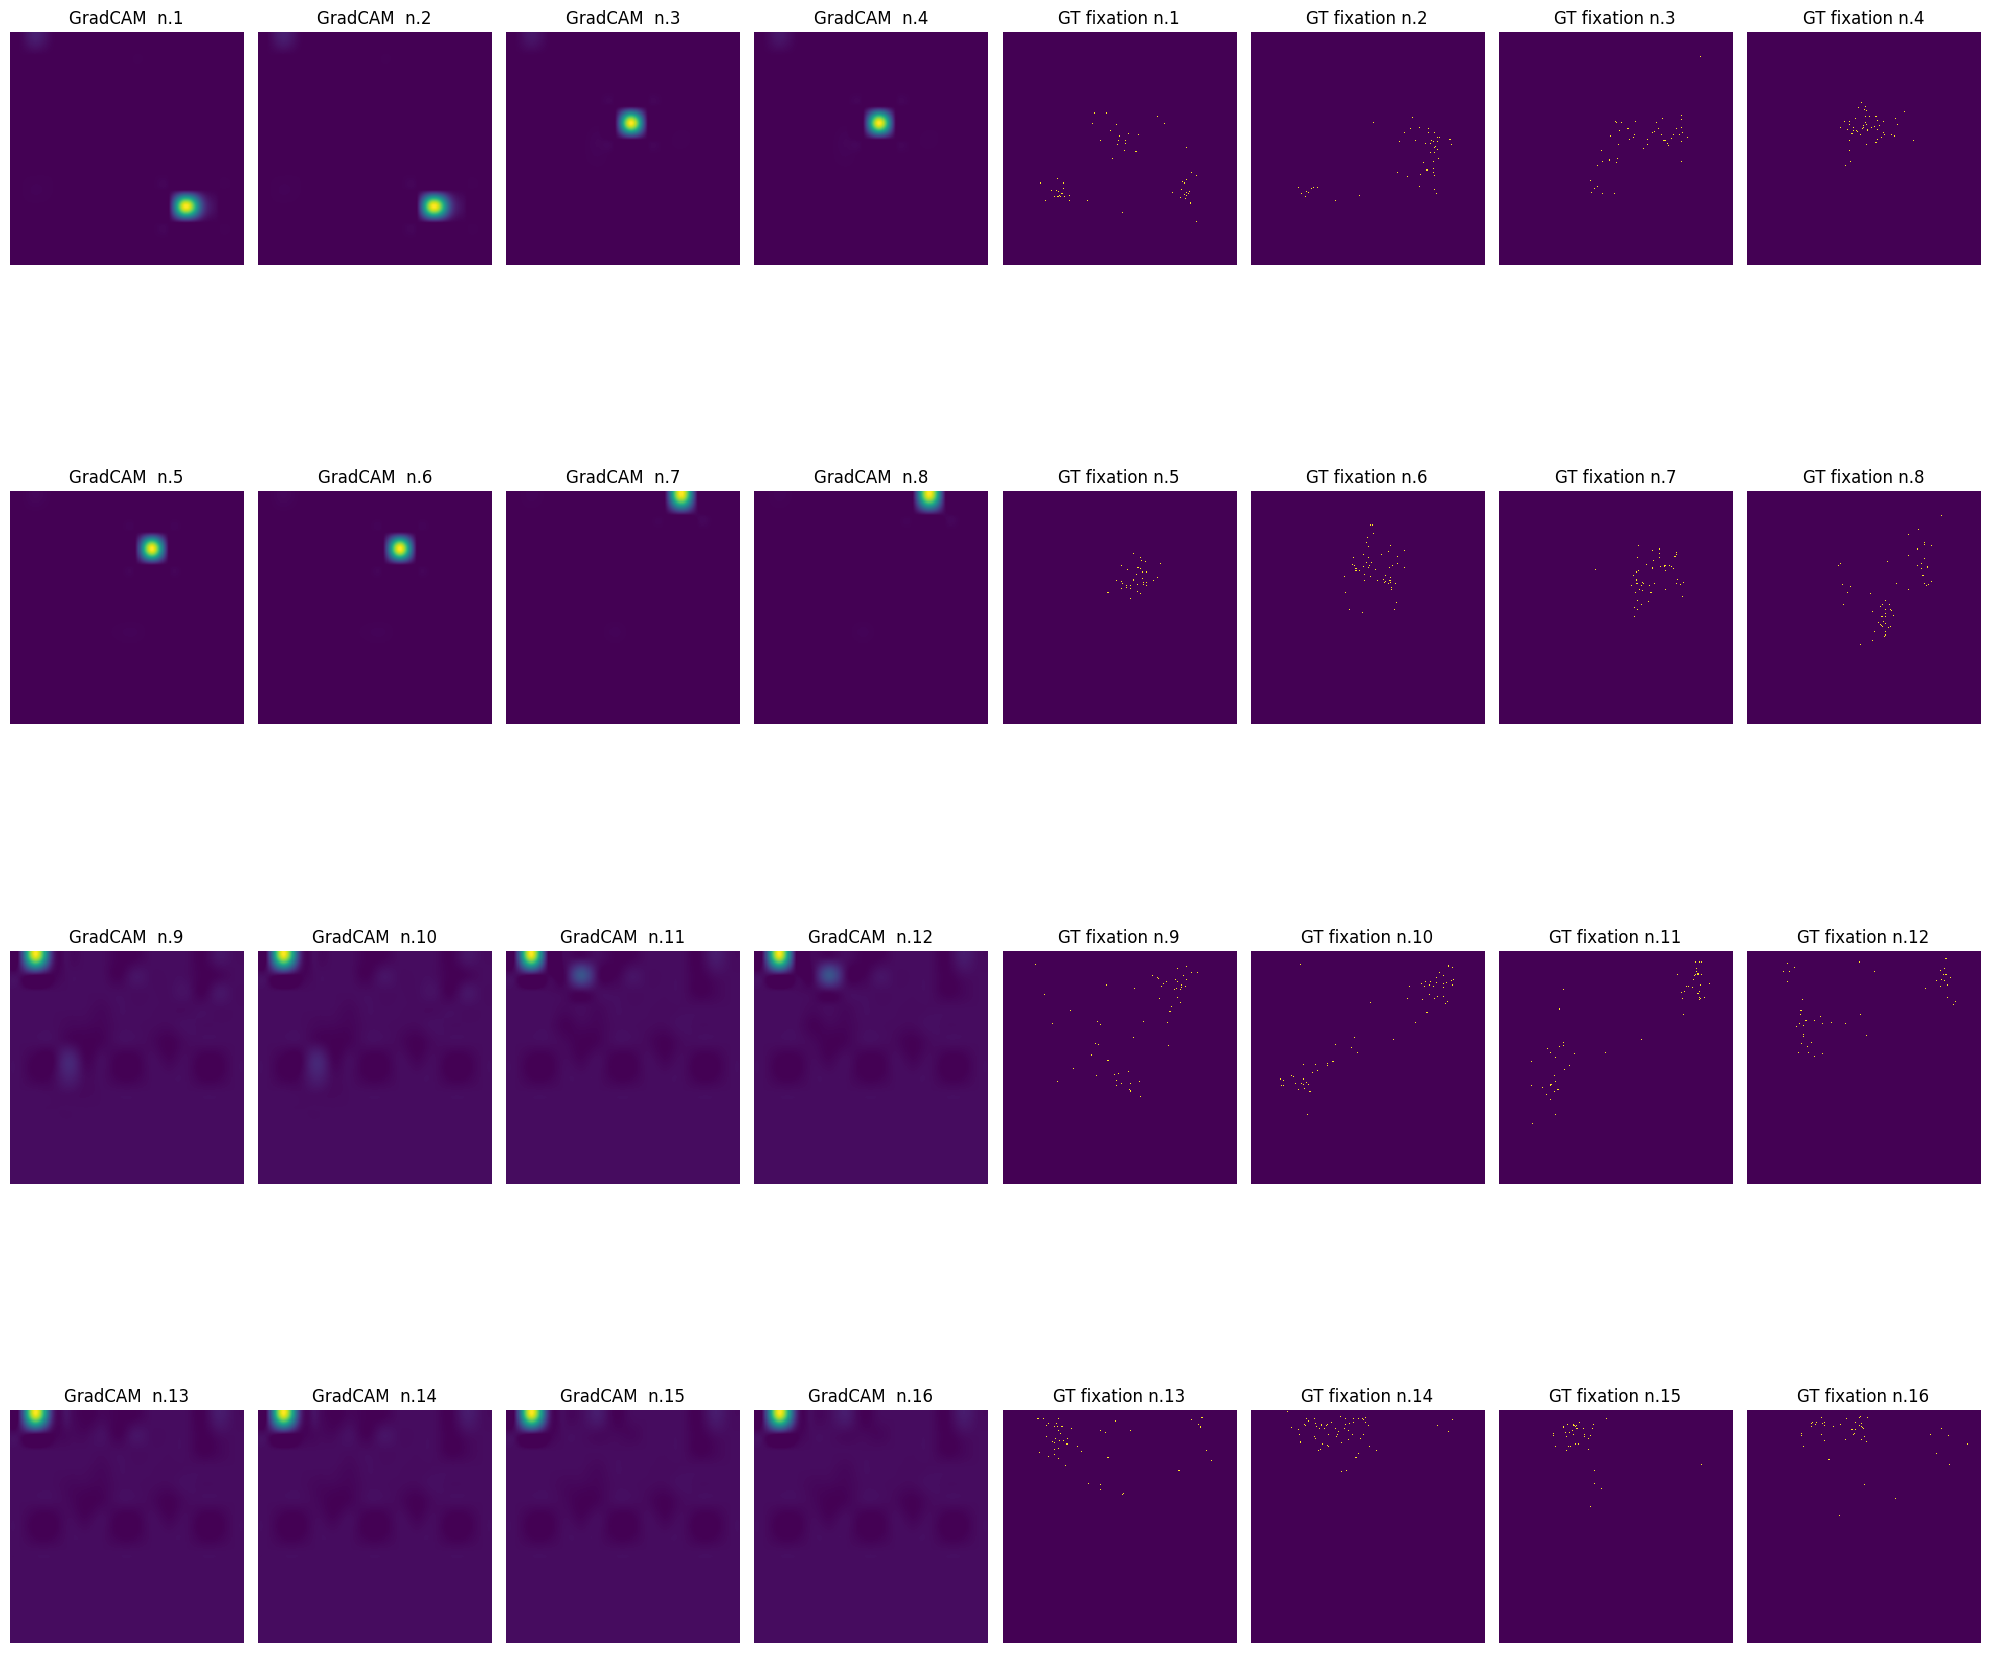

Average AUC Judd: 0.4019813200463853
Average NSS: 0.36247471483902655
Average CC: 0.011287782763059683
Average KLdiv: 8.822235230336856
Max AUC Judd: 0.6647277140552791
Max NSS: 3.5864061781193217
Max CC: 0.11212995739545169
Min KLdiv: 7.291285740447391


Text(0.5, 1.0, 'KLdiv')

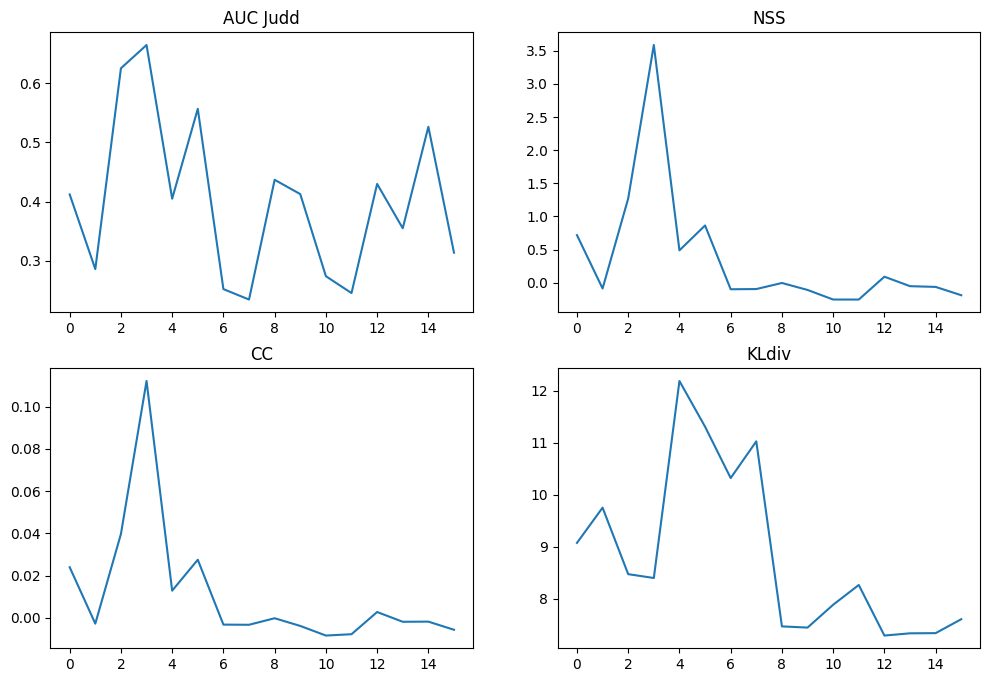

In [40]:
#load the data and then take the 16 frames and create an overall map
data = np.load(f'gradcam/balanced/vivit/{video}_attn_mean.npy')

# Check the shape of the data
print("Data shape:", data.shape)  # Should be (16, 700, 700)
# Create a 16 x 224 x 224 matrix
heatmap_2d = np.zeros((16, 224, 224))

for i in range(16):
    heatmap_2d [i,:,:] = zoom(data[i,:,:], (224/700, 224/700), order=3) #interpolazione bicubica: media pesata dei 16 pixel circondanti


#CONTROLL LINE: if heatmap value is below 0 set it to 0
heatmap_2d[heatmap_2d < 0] = 0

#load the heatmap
temporal_Fixation_map = np.load(f'fixations/{video}/temporal_Fixation_map.npy')
#load the gradcam
normalized_heatmap = heatmap_2d

gt = [temporal_Fixation_map[:, :, i] for i in range(16)]
s_map = [normalized_heatmap[i, :, :] for i in range(16)]

#for all the gt if it is 0 keep it 0, otherwise set it to 1
for i in range(len(gt)):
    gt[i][gt[i] > 0] = 1
gt_distribution = []
for i in range(len(gt)):
    distr= gaussian_filter(gt[i], sigma=2.3)
    #normalize the distribution
    norm_distr = distr / np.sum(distr)
    gt_distribution.append(norm_distr)


#for each of the 16 frames, compute the metrics
AUC_Judd_list = []
NSS_list = []
CC_list = []
KLdiv_list= []

print("s_map shape", s_map[0].shape)

for i in range(16):
    AUC_Judd_list.append(AUC_Judd(s_map[i], gt[i]))
    NSS_list.append(NSS(s_map[i], gt[i]))
    CC_list.append(CC(s_map[i], gt[i]))
    KLdiv_list.append(KLdiv(s_map[i], gt[i]))


fig, axs = plt.subplots(4, 8, figsize=(20, 20))
for i in range(4):
    for j in range(4):
        #plot the saiency
        axs[i, j].imshow(s_map[i * 4 + j], cmap='viridis', interpolation='nearest')
        #plot in the nect slot the gt
        axs[i, j + 4].imshow(gt[i * 4 + j], cmap='viridis', interpolation='nearest')
        axs[i, j].set_title(f'GradCAM  n.{i * 4 + j+1}')
        axs[i, j + 4].set_title(f'GT fixation n.{i * 4 + j+1}')
        axs[i, j].axis('off')
        axs[i, j + 4].axis('off')
plt.tight_layout()
plt.show()

#compute and print the average of the metrics
print('Average AUC Judd:', np.mean(AUC_Judd_list))
print('Average NSS:', np.mean(NSS_list))
print('Average CC:', np.mean(CC_list))
print('Average KLdiv:', np.mean(KLdiv_list))


#max value of the metrics
print('Max AUC Judd:', np.max(AUC_Judd_list))
print('Max NSS:', np.max(NSS_list))
print('Max CC:', np.max(CC_list))
print('Min KLdiv:', np.min(KLdiv_list))

fig, axs = plt.subplots(2, 2, figsize=(12, 8))
axs[0, 0].plot(AUC_Judd_list)
axs[0, 0].set_title('AUC Judd')
axs[0, 1].plot(NSS_list)
axs[0, 1].set_title('NSS')
axs[1, 0].plot(CC_list)
axs[1, 0].set_title('CC')
axs[1, 1].plot(KLdiv_list)
axs[1, 1].set_title('KLdiv')

### Gathering all the temporal metrics in one excel

In [2]:
def temporal_metrics(video_name,model_name):

    #load the heatmap
    temporal_Fixation_map = np.load(f'fixations/{video_name}/temporal_Fixation_map.npy')
    #load the gradcam
    ###for CNN
    #normalized_heatmap = np.load(f'gradcams/{model_name}/{video_name}_gradCAMs.npy')
    ### for TRANSFORMER
    normalized_heatmap = np.load(f'gradcams/balanced/{model_name}/{video_name}_attn_mean.npy')


    gt = [temporal_Fixation_map[:, :, i] for i in range(16)]
        
    ###CNN
    #s_map = [normalized_heatmap[:, :, i] for i in range(16)]  
    
    ### TRANSORMER
    # heatmap_2d = np.zeros((16, 224, 224))
    # for i in range(16):
    #     heatmap_2d[i,:,:] = zoom(normalized_heatmap[i,:,:], (224/700, 224/700), order=3) #interpolazione bicubica: media pesata dei 16 pixel circondanti
    # #CONTROLL LINE #if heatmap value is below 0 set it to 0
    # heatmap_2d[heatmap_2d < 0] = 0

   #s_map = [heatmap_2d[i, :, :] for i in range(16)]
    s_map = [normalized_heatmap[i, :, :] for i in range(16)]

    #for all the gt if it is 0 keep it 0, otherwise set it to 1
    for i in range(len(gt)):
        gt[i][gt[i] > 0] = 1
    gt_distribution = []
    for i in range(len(gt)):
        distr= gaussian_filter(gt[i], sigma=2.3)
        #normalize the distribution
        norm_distr = distr / np.sum(distr)
        gt_distribution.append(norm_distr)


    #for each of the 16 frames, compute the metrics
    AUC_Judd_list = []
    NSS_list = []
    CC_list = []
    KLdiv_list= []

    for i in range(16):
        AUC_Judd_list.append(AUC_Judd(s_map[i], gt[i]))
        NSS_list.append(NSS(s_map[i], gt[i]))
        CC_list.append(CC(s_map[i], gt_distribution[i]))
        KLdiv_list.append(KLdiv(s_map[i], gt_distribution[i]))

    return AUC_Judd_list, NSS_list, CC_list, KLdiv_list


In [10]:
#for all the videos in gaze videos but saving in a dictionary the metrics list results

metrics_dict = {}

for video in gaze_videos:
    AUC_Judd_list, NSS_list, CC_list, KLdiv_list = temporal_metrics(video,'timesformer_new')
    metrics_dict[video] = {
        'AUC_Judd': AUC_Judd_list,
        'NSS': NSS_list,
        'CC': CC_list,
        'KLdiv': KLdiv_list
    }

# Save the metrics dictionary to a file excel


# # Create a Pandas Excel writer using XlsxWriter as the engine.
excel_file = 'metrics_results.xlsx'

with pd.ExcelWriter(excel_file, engine='openpyxl') as writer:
    # Loop through the dictionary and create a DataFrame for each video
    for video, metrics in metrics_dict.items():
        df = pd.DataFrame(metrics)
        # Save the DataFrame to a new sheet in the Excel file
        df.to_excel(writer, sheet_name=video, index=False)

In [308]:
def heatmaps_both(video_name,model_name, network_type='CNN'):

    #load the heatmap
    temporal_Fixation_map = np.load(f'fixations/{video_name}/temporal_Fixation_map.npy')

    gt = [temporal_Fixation_map[:, :, i] for i in range(16)]
    

    if network_type== 'CNN':
        normalized_heatmap = np.load(f'gradcams/balanced/{model_name}/{video_name}_gradCAMs.npy')
        s_map = [normalized_heatmap[:, :, i] for i in range(16)]  
    elif network_type == 'Transformer':
        normalized_heatmap = np.load(f'gradcams/balanced/{model_name}/{video_name}_attn_mean.npy')
        s_map = [normalized_heatmap[i, :, :] for i in range(16)]
    else:
        raise ValueError("type must be either 'CNN' or 'Transformer'")


    
    #for all the gt if it is 0 keep it 0, otherwise set it to 1
    for i in range(len(gt)):
        gt[i][gt[i] > 0] = 1
    gt_distribution = []
    for i in range(len(gt)):
        distr= gaussian_filter(gt[i], sigma=2.3)
        #normalize the distribution
        norm_distr = distr / np.sum(distr)
        gt_distribution.append(norm_distr)


    #for each of the 16 frames, compute the metrics
    AUC_Judd_list = []
    NSS_list = []
    CC_list = []
    KLdiv_list= []

    for i in range(16):
        AUC_Judd_list.append(AUC_Judd(s_map[i], gt[i]))
        NSS_list.append(NSS(s_map[i], gt[i]))
        CC_list.append(CC(s_map[i], gt_distribution[i]))
        KLdiv_list.append(KLdiv(s_map[i], gt_distribution[i]))

    
    fig, axs = plt.subplots(4, 8, figsize=(20, 20))
    for i in range(4):
        for j in range(4):
            #plot the saiency
            axs[i, j].imshow(s_map[i * 4 + j], cmap='viridis', interpolation='nearest')
            #plot in the nect slot the gt
            axs[i, j + 4].imshow(gt[i * 4 + j], cmap='viridis', interpolation='nearest')
            axs[i, j].set_title(f'GradCAM  n.{i * 4 + j+1}')
            axs[i, j + 4].set_title(f'GT fixation n.{i * 4 + j+1}')
            axs[i, j].axis('off')
            axs[i, j + 4].axis('off')
    plt.tight_layout()

    return AUC_Judd_list, NSS_list, CC_list, KLdiv_list


def heatmaps_both_selection(video_name,model_name, network_type='CNN'):

    #load the heatmap
    temporal_Fixation_map = np.load(f'fixations/{video_name}/temporal_Fixation_map.npy')

    gt = [temporal_Fixation_map[:, :, i] for i in range(16)]
    

    if network_type== 'CNN':
        normalized_heatmap = np.load(f'gradcams/balanced/{model_name}/{video_name}_gradCAMs.npy')
        s_map = [normalized_heatmap[:, :, i] for i in range(16)]  
    elif network_type == 'Transformer':
        normalized_heatmap = np.load(f'gradcams/balanced/{model_name}/{video_name}_attn_mean.npy')
        s_map = [normalized_heatmap[i, :, :] for i in range(16)]
    else:
        raise ValueError("type must be either 'CNN' or 'Transformer'")


    
    #for all the gt if it is 0 keep it 0, otherwise set it to 1
    for i in range(len(gt)):
        gt[i][gt[i] > 0] = 1
    gt_distribution = []
    for i in range(len(gt)):
        distr= gaussian_filter(gt[i], sigma=2.3)
        #normalize the distribution
        norm_distr = distr / np.sum(distr)
        gt_distribution.append(norm_distr)


    #for each of the 16 frames, compute the metrics
    AUC_Judd_list = []
    NSS_list = []
    CC_list = []
    KLdiv_list= []

    for i in range(16):
        AUC_Judd_list.append(AUC_Judd(s_map[i], gt[i]))
        NSS_list.append(NSS(s_map[i], gt[i]))
        CC_list.append(CC(s_map[i], gt_distribution[i]))
        KLdiv_list.append(KLdiv(s_map[i], gt_distribution[i]))

    
    fig, axs = plt.subplots(1, 4, figsize=(10,10))
    #plot only 4,8,12,16 heatmaps without ground truth
    for i in range(4):
        axs[i].imshow(s_map[i * 4 + 3], cmap='viridis', interpolation='nearest')
        #axs[i].set_title(f'{model_name} attention n.{i * 4 + 4}')
        axs[i].axis('off')
    plt.tight_layout()
    #print colorbar
    #plt.colorbar(axs[0].images[0], ax=axs, orientation='vertical', fraction=0.02, pad=0.04)

    return AUC_Judd_list, NSS_list, CC_list, KLdiv_list



#plot only the ground truth apart
def ground_truth_heatmaps(video_name):

    #load the heatmap
    temporal_Fixation_map = np.load(f'fixations/{video_name}/temporal_Fixation_map.npy')

    gt = [temporal_Fixation_map[:, :, i] for i in range(16)]

    #apply a gaussian filter to the ground truth
    gt = [gaussian_filter(gt[i], sigma=2.3) for i in range(16)]

    #now superimpose the heatmap to the image
    plt.axis('off')
    plt.show()


    fig, axs = plt.subplots(1, 4, figsize=(10,10))
    #plot only 4,8,12,16 heatmaps without ground truth
    for i in range(4):
        image = cv2.imread(f'/figure_2_ICCV_images/fig4_{i+1}.png')
        gt[i * 4 + 3] = cv2.resize(gt[i * 4 + 3], (image.shape[1], image.shape[0]))
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        axs[i].imshow(image, alpha=0.9)
        axs[i].imshow(gt[i * 4 + 3], cmap='viridis', alpha=0.5)
        axs[i].set_title(f'Frame n.{i * 4 + 4}')
        #set font bold and size 14
        axs[i].title.set_fontsize(24)
        axs[i].title.set_fontweight('bold')
        axs[i].axis('off')
    plt.tight_layout()

In [ ]:
def plot_heatmaps(video_name, model_name, network):
    AUC_Judd_list, NSS_list, CC_list, KLdiv_list = heatmaps_both_selection(video_name, model_name, network)

# Example usage
video= '1_ca_SW_Help__r2__100'
plot_heatmaps(video, 'TSM', 'CNN')
plot_heatmaps(video, 'TSN', 'CNN')
plot_heatmaps(video, 'TANet', 'CNN')
plot_heatmaps(video, 'ViViT', 'Transformer')
plot_heatmaps(video, 'Timesformer', 'Transformer')

ground_truth_heatmaps(video)

## Aggregate similarity metrics overall

In [177]:
def total_metrics(video_name, model_name, network_type='CNN'):

    #load the heatmap
    temporal_Fixation_map = np.load(f'fixations/{video_name}/temporal_Fixation_map.npy')

    gt = [temporal_Fixation_map[:, :, i] for i in range(16)]

    

    if network_type== 'CNN':
        normalized_heatmap = np.load(f'gradcams/balanced/{model_name}/{video_name}_gradCAMs.npy')
        s_map = [normalized_heatmap[:, :, i] for i in range(16)]  
    elif network_type == 'Transformer':
        normalized_heatmap = np.load(f'gradcams/balanced/{model_name}/{video_name}_attn_mean.npy')
        s_map = [normalized_heatmap[i, :, :] for i in range(16)]
    else:
        raise ValueError("type must be either 'CNN' or 'Transformer'")

    #sum the heatmaps
    
    overall_s_map = np.sum(s_map, axis=0)
    #s_map shape in the three dimension one by one
    #print("s_map first dimensoin shape:", s_map[0].shape, "second dimension shape:", s_map[1].shape, "third dimension shape:", s_map[2].shape, "fourth dimension shape:", s_map[3].shape, "... last dimension shape:", s_map[15].shape, "and it is number of frames:", len(s_map))
    print("Overall heatmap shape:", overall_s_map.shape)
    overall_gt = np.sum(gt, axis=0)
    #print("gt first dimensoin shape:", gt[0].shape, "second dimension shape:", gt[1].shape, "third dimension shape:", gt[2].shape, "fourth dimension shape:", gt[3].shape, "... last dimension shape:", gt[15].shape, "and it is number of frames:", len(gt))
    print("Overall ground truth shape:", overall_gt.shape)

    #normalize the overall heatmap
    overall_s_map = overall_s_map / np.sum(overall_s_map)
    #if it is 0 keep it 0, otherwise set it to 1
    overall_gt[overall_gt > 0] = 1
    #apply a gaussian filter to the overall ground truth
    overall_gt_distribution = gaussian_filter(overall_gt, sigma=2.3)
    overall_gt_distribution = overall_gt_distribution / np.sum(overall_gt_distribution)



    #compute the metrics
    AUC_Judd_val = AUC_Judd(overall_s_map, overall_gt)
    NSS_val = NSS(overall_s_map, overall_gt)
    CC_val = CC(overall_s_map, overall_gt_distribution)
    KLdiv_val = KLdiv(overall_s_map, overall_gt_distribution)

    return AUC_Judd_val, NSS_val, CC_val, KLdiv_val
    

In [178]:
for model_name, typology in ['TSM', 'CNN'], ['TSN', 'CNN'], ['TANet', 'CNN'], ['ViViT', 'Transformer'], ['Timesformer', 'Transformer']:
    metrics_dict = {}
    for video in gaze_videos:
        AUC_Judd_value, NSS_value, CC_value, KLdiv_value = total_metrics(video, model_name, network_type=typology)
        metrics_dict[video] = {
            'AUC_Judd': AUC_Judd_value,
            'NSS': NSS_value,
            'CC': CC_value,
            'KLdiv': KLdiv_value
        }

    print("================================================================================================================================")
    print(model_name)
    # print the average, the std deviation of the AUC_Judd, NSS, CC, KLdiv
    avg_AUC_Judd = np.mean([metrics['AUC_Judd'] for metrics in metrics_dict.values()])
    avg_NSS = np.mean([metrics['NSS'] for metrics in metrics_dict.values()])
    avg_CC = np.mean([metrics['CC'] for metrics in metrics_dict.values()])
    avg_KLdiv = np.mean([metrics['KLdiv'] for metrics in metrics_dict.values()])
    std_AUC_Judd = np.std([metrics['AUC_Judd'] for metrics in metrics_dict.values()])
    std_NSS = np.std([metrics['NSS'] for metrics in metrics_dict.values()])
    std_CC = np.std([metrics['CC'] for metrics in metrics_dict.values()])
    std_KLdiv = np.std([metrics['KLdiv'] for metrics in metrics_dict.values()])

    #round to the second decimal
    print('Average AUC Judd:', np.round(avg_AUC_Judd, 2), "+-" , np.round(std_AUC_Judd, 2))
    print('Average NSS:', np.round(avg_NSS, 2), "+-" , np.round(std_NSS, 2))
    print('Average CC:', np.round(avg_CC, 2), "+-" , np.round(std_CC, 2))
    print('Average KLdiv:', np.round(avg_KLdiv, 2), "+-" , np.round(std_KLdiv, 2))


    #now print avg e std dev of video that contains Hinder in their name round to the second decimal
    hinder_videos = [video for video in balanced_plus_gaze_videos if 'Hinder' in video]
    avg_AUC_Judd_hinder = np.mean([metrics_dict[video]['AUC_Judd'] for video in hinder_videos])
    avg_NSS_hinder = np.mean([metrics_dict[video]['NSS'] for video in hinder_videos])
    avg_CC_hinder = np.mean([metrics_dict[video]['CC'] for video in hinder_videos])
    avg_KLdiv_hinder = np.mean([metrics_dict[video]['KLdiv'] for video in hinder_videos])
    std_AUC_Judd_hinder = np.std([metrics_dict[video]['AUC_Judd'] for video in hinder_videos])
    std_NSS_hinder = np.std([metrics_dict[video]['NSS'] for video in hinder_videos])
    std_CC_hinder = np.std([metrics_dict[video]['CC'] for video in hinder_videos])
    std_KLdiv_hinder = np.std([metrics_dict[video]['KLdiv'] for video in hinder_videos])
    print('Average AUC Judd Hinder:', np.round(avg_AUC_Judd_hinder, 2), "+-" , np.round(std_AUC_Judd_hinder, 2))
    print('Average NSS Hinder:', np.round(avg_NSS_hinder, 2), "+-" , np.round(std_NSS_hinder, 2))
    print('Average CC Hinder:', np.round(avg_CC_hinder, 2), "+-" , np.round(std_CC_hinder, 2))
    print('Average KLdiv Hinder:', np.round(avg_KLdiv_hinder, 2), "+-" , np.round(std_KLdiv_hinder, 2))
    #now print avg e std dev of video that contains Help in their name
    help_videos = [video for video in balanced_plus_gaze_videos if 'Help' in video]
    avg_AUC_Judd_help = np.mean([metrics_dict[video]['AUC_Judd'] for video in help_videos])
    avg_NSS_help = np.mean([metrics_dict[video]['NSS'] for video in help_videos])
    avg_CC_help = np.mean([metrics_dict[video]['CC'] for video in help_videos])
    avg_KLdiv_help = np.mean([metrics_dict[video]['KLdiv'] for video in help_videos])
    std_AUC_Judd_help = np.std([metrics_dict[video]['AUC_Judd'] for video in help_videos])
    std_NSS_help = np.std([metrics_dict[video]['NSS'] for video in help_videos])
    std_CC_help = np.std([metrics_dict[video]['CC'] for video in help_videos])
    std_KLdiv_help = np.std([metrics_dict[video]['KLdiv'] for video in help_videos])
    print('Average AUC Judd Help:', np.round(avg_AUC_Judd_help, 2), "+-" , np.round(std_AUC_Judd_help, 2))
    print('Average NSS Help:', np.round(avg_NSS_help, 2), "+-" , np.round(std_NSS_help, 2))
    print('Average CC Help:', np.round(avg_CC_help, 2), "+-" , np.round(std_CC_help, 2))
    print('Average KLdiv Help:', np.round(avg_KLdiv_help, 2), "+-" , np.round(std_KLdiv_help, 2))
        

    #now print avg e std dev of video that contains Physical in their name
    physical_videos = [video for video in balanced_plus_gaze_videos if 'Physical' in video]
    avg_AUC_Judd_physical = np.mean([metrics_dict[video]['AUC_Judd'] for video in physical_videos])
    avg_NSS_physical = np.mean([metrics_dict[video]['NSS'] for video in physical_videos])
    avg_CC_physical = np.mean([metrics_dict[video]['CC'] for video in physical_videos])
    avg_KLdiv_physical = np.mean([metrics_dict[video]['KLdiv'] for video in physical_videos])
    std_AUC_Judd_physical = np.std([metrics_dict[video]['AUC_Judd'] for video in physical_videos])
    std_NSS_physical = np.std([metrics_dict[video]['NSS'] for video in physical_videos])
    std_CC_physical = np.std([metrics_dict[video]['CC'] for video in physical_videos])
    std_KLdiv_physical = np.std([metrics_dict[video]['KLdiv'] for video in physical_videos])
    print('Average AUC Judd Physical:', np.round(avg_AUC_Judd_physical, 2), "+-" , np.round(std_AUC_Judd_physical, 2))
    print('Average NSS Physical:', np.round(avg_NSS_physical, 2), "+-" , np.round(std_NSS_physical, 2))
    print('Average CC Physical:', np.round(avg_CC_physical, 2), "+-" , np.round(std_CC_physical, 2))
    print('Average KLdiv Physical:', np.round(avg_KLdiv_physical, 2), "+-" , np.round(std_KLdiv_physical, 2))

s_map first dimensoin shape: (224, 224) second dimension shape: (224, 224) third dimension shape: (224, 224) fourth dimension shape: (224, 224) ... last dimension shape: (224, 224) and it is number of frames: 16
Overall heatmap shape: (224, 224)
gt first dimensoin shape: (224, 224) second dimension shape: (224, 224) third dimension shape: (224, 224) fourth dimension shape: (224, 224) ... last dimension shape: (224, 224) and it is number of frames: 16
Overall ground truth shape: (224, 224)
s_map first dimensoin shape: (224, 224) second dimension shape: (224, 224) third dimension shape: (224, 224) fourth dimension shape: (224, 224) ... last dimension shape: (224, 224) and it is number of frames: 16
Overall heatmap shape: (224, 224)
gt first dimensoin shape: (224, 224) second dimension shape: (224, 224) third dimension shape: (224, 224) fourth dimension shape: (224, 224) ... last dimension shape: (224, 224) and it is number of frames: 16
Overall ground truth shape: (224, 224)
s_map first 

In [278]:
def plot_total_heatmap(video_name, model_name, network_type='CNN'):

    if network_type== 'CNN':
        normalized_heatmap = np.load(f'gradcams/balanced/{model_name}/{video_name}_gradCAMs.npy')
        s_map = [normalized_heatmap[:, :, i] for i in range(16)]  
    elif network_type == 'Transformer':
        normalized_heatmap = np.load(f'gradcams/balanced/{model_name}/{video_name}_attn_mean.npy')
        s_map = [normalized_heatmap[i, :, :] for i in range(16)]
    else:
        raise ValueError("type must be either 'CNN' or 'Transformer'")

    #sum the heatmaps
    
    overall_s_map = np.sum(s_map, axis=0)
    #s_map shape in the three dimension one by one
    #print("s_map first dimensoin shape:", s_map[0].shape, "second dimension shape:", s_map[1].shape, "third dimension shape:", s_map[2].shape, "fourth dimension shape:", s_map[3].shape, "... last dimension shape:", s_map[15].shape, "and it is number of frames:", len(s_map))

    #normalize the overall heatmap
    overall_s_map = overall_s_map / np.sum(overall_s_map)
    #apply a gaussian filter to the overall ground truth
    print("Model:", model_name, "Video:", video_name)
    #s_map
    plt.imshow(overall_s_map, cmap='viridis', interpolation='nearest')
    #plt.title(f'Saliency Map {video_name}')
    plt.axis('off')
    plt.show()

    return 

def plot_total_GT(video_name, video_frame):

    #load the heatmap
    temporal_Fixation_map = np.load(f'fixations/{video_name}/temporal_Fixation_map.npy')

    gt = [temporal_Fixation_map[:, :, i] for i in range(16)]

    overall_gt = np.sum(gt, axis=0)
    #print("gt first dimensoin shape:", gt[0].shape, "second dimension shape:", gt[1].shape, "third dimension shape:", gt[2].shape, "fourth dimension shape:", gt[3].shape, "... last dimension shape:", gt[15].shape, "and it is number of frames:", len(gt))
    overall_gt[overall_gt > 0] = 1
    #apply a gaussian filter to the overall ground truth
    overall_gt_distribution = gaussian_filter(overall_gt, sigma=2.3)
    overall_gt_distribution = overall_gt_distribution / np.sum(overall_gt_distribution)


    print("GT for Video:", video_name)
    #overall_gt_distribution
    #superimpose the hetmap to the image in /figure_2_ICCV_images/Help.png 

    #load the image
    image_path = f'/figure_2_ICCV_images/{video_frame}'
    image = cv2.imread(image_path)
    #resize the image to the same size of the heatmap
    #image = cv2.resize(image, (overall_gt_distribution.shape[1], overall_gt_distribution.shape[0]))
    overall_gt_distribution = cv2.resize(overall_gt_distribution, (image.shape[1], image.shape[0]))
    #convert the image to RGB
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    #create a figure
    plt.figure(figsize=(10, 10))
    #plot the image
    plt.imshow(image, alpha=0.9)
    #plot the heatmap but if it is under a threshold make it transparent
    plt.imshow(overall_gt_distribution, cmap='viridis', alpha=0.4)


    #now superimpose the heatmap to the image
    plt.axis('off')
    plt.show()

    return 

Model: TSM Video: 3_bc_WS_Help__r4__100


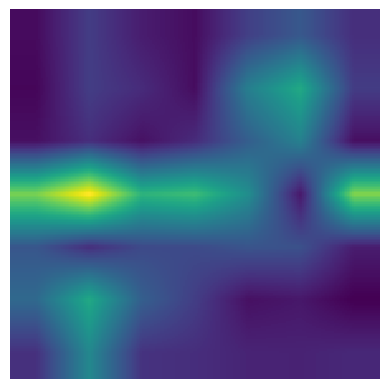

Model: TSN Video: 3_bc_WS_Help__r4__100


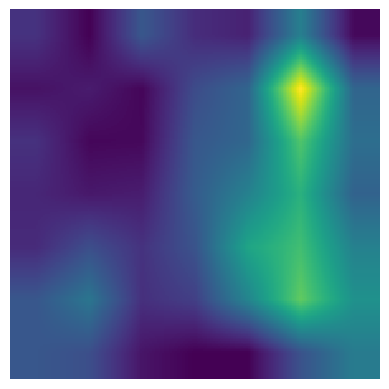

Model: TANet Video: 3_bc_WS_Help__r4__100


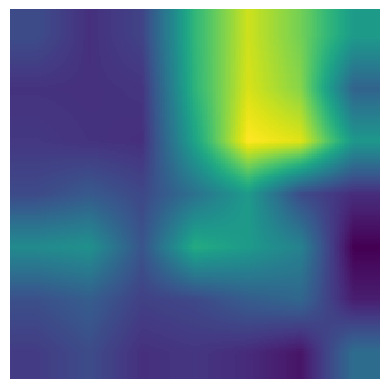

Model: ViViT Video: 3_bc_WS_Help__r4__100


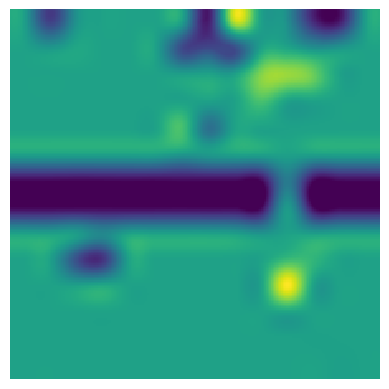

Model: Timesformer Video: 3_bc_WS_Help__r4__100


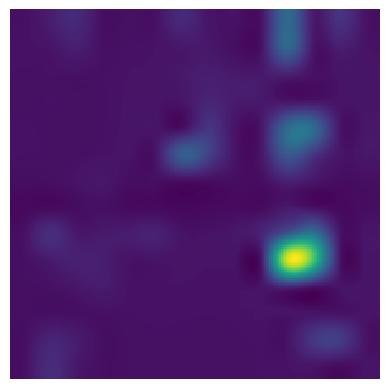

GT for Video: 3_bc_WS_Help__r4__100


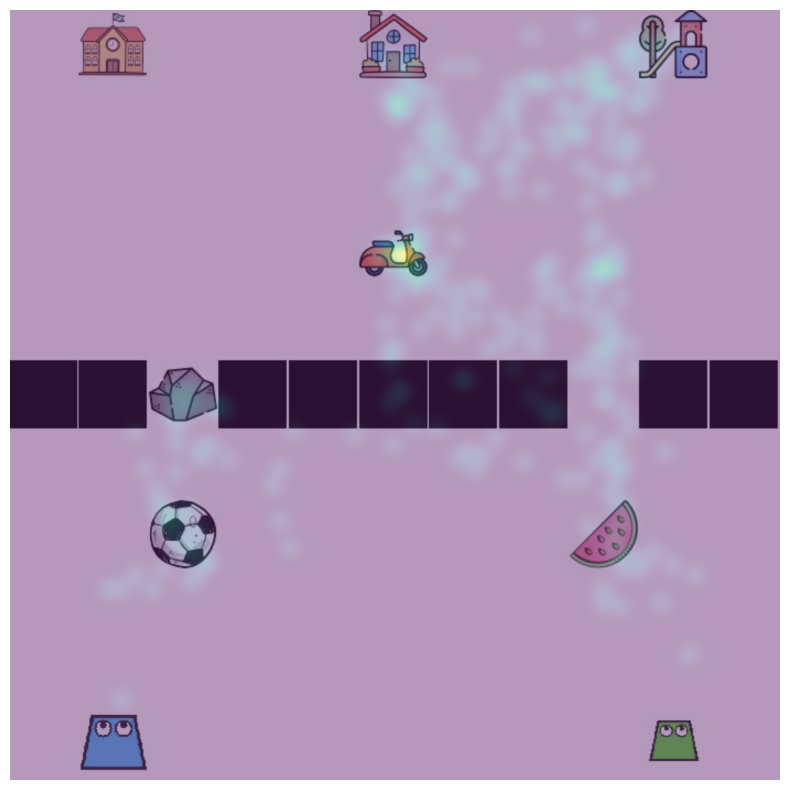

Model: TSM Video: 3_ab_SW_Hinder__r5__100


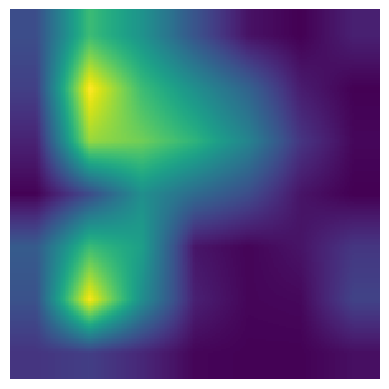

Model: TSN Video: 3_ab_SW_Hinder__r5__100


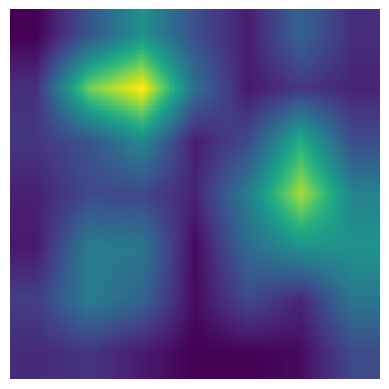

Model: TANet Video: 3_ab_SW_Hinder__r5__100


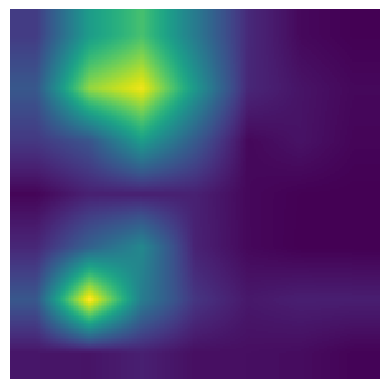

Model: ViViT Video: 3_ab_SW_Hinder__r5__100


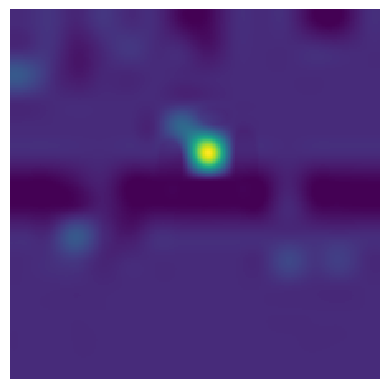

Model: Timesformer Video: 3_ab_SW_Hinder__r5__100


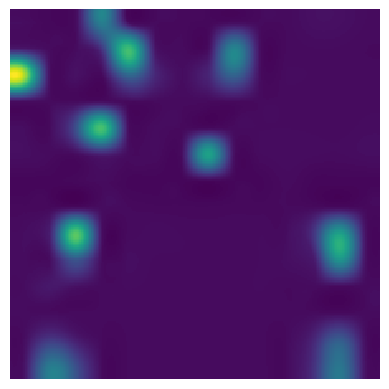

GT for Video: 3_ab_SW_Hinder__r5__100


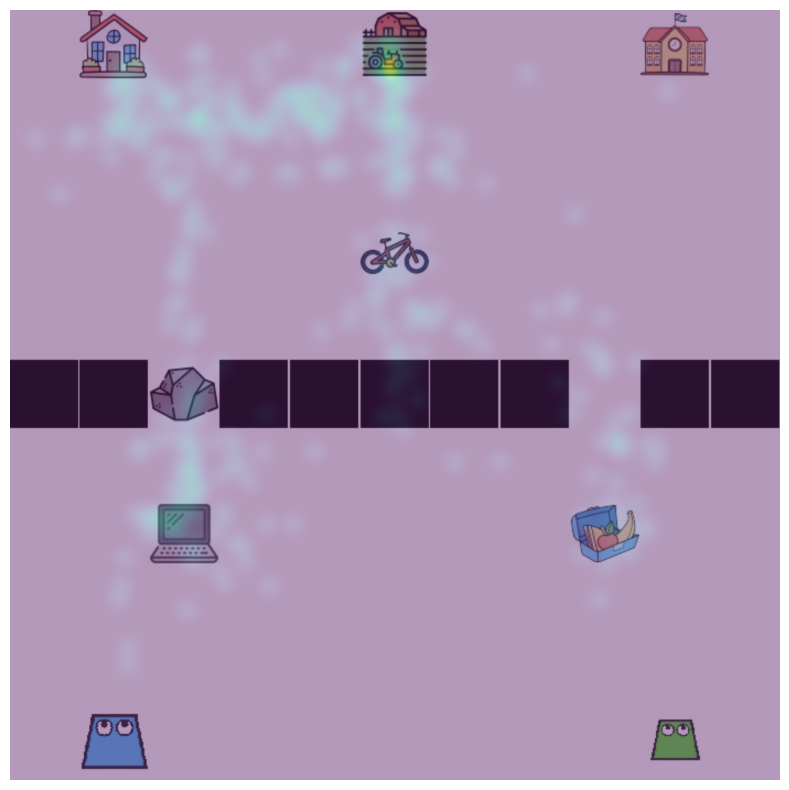

Model: TSM Video: 1_ca_WS_Physical__r2__100


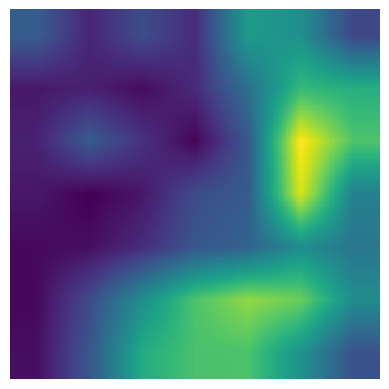

Model: TSN Video: 1_ca_WS_Physical__r2__100


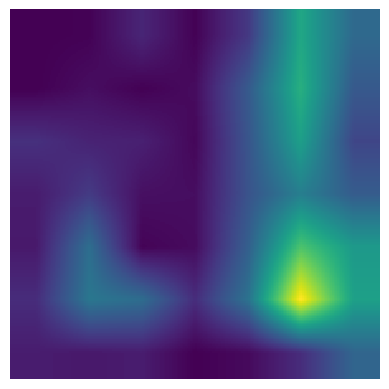

Model: TANet Video: 1_ca_WS_Physical__r2__100


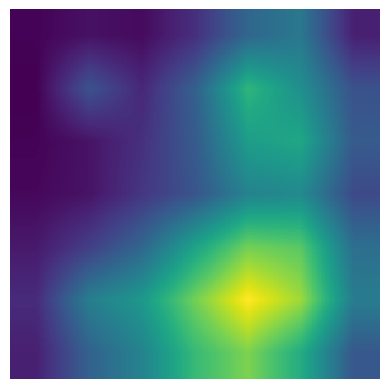

Model: ViViT Video: 1_ca_WS_Physical__r2__100


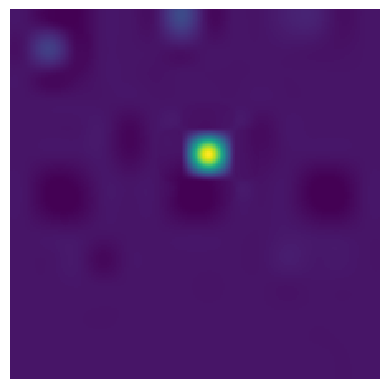

Model: Timesformer Video: 1_ca_WS_Physical__r2__100


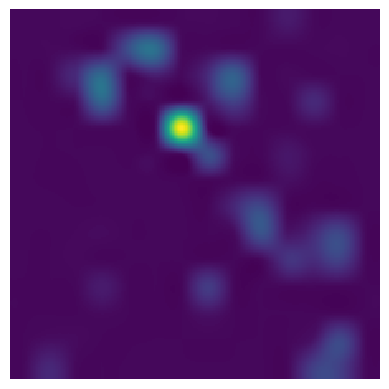

GT for Video: 1_ca_WS_Physical__r2__100


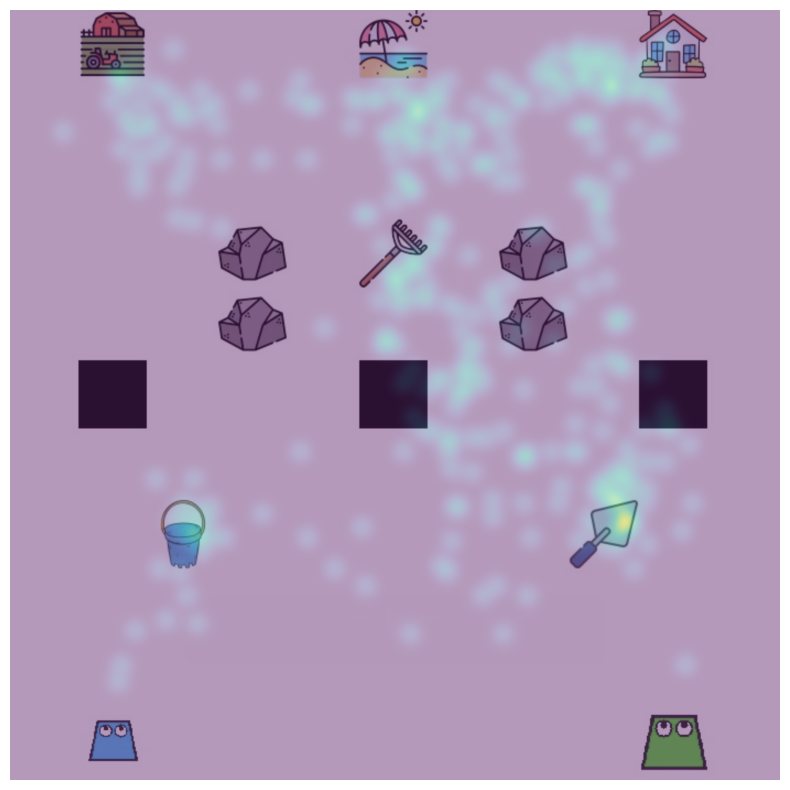

In [279]:
video='3_bc_WS_Help__r4__100'
plot_total_heatmap(video, 'TSM', 'CNN')
plot_total_heatmap(video, 'TSN', 'CNN')
plot_total_heatmap(video, 'TANet', 'CNN')
plot_total_heatmap(video, 'ViViT', 'Transformer')
plot_total_heatmap(video, 'Timesformer', 'Transformer')

plot_total_GT(video, 'Help.png')

video='3_ab_SW_Hinder__r5__100'
plot_total_heatmap(video, 'TSM', 'CNN')
plot_total_heatmap(video, 'TSN', 'CNN')
plot_total_heatmap(video, 'TANet', 'CNN')
plot_total_heatmap(video, 'ViViT', 'Transformer')
plot_total_heatmap(video, 'Timesformer', 'Transformer')
plot_total_GT(video, 'Hinder.png')



video='1_ca_WS_Physical__r2__100'
plot_total_heatmap(video, 'TSM', 'CNN')
plot_total_heatmap(video, 'TSN', 'CNN')
plot_total_heatmap(video, 'TANet', 'CNN')
plot_total_heatmap(video, 'ViViT', 'Transformer')
plot_total_heatmap(video, 'Timesformer', 'Transformer')
plot_total_GT(video, 'Physical.png')